# imports:

In [1]:
from os import listdir,mkdir,makedirs
from os.path import isfile, join, isdir,exists
import pandas as pd
import numpy as np
from scipy import stats
import re
import time
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from myplots import roundup, rounddown, find_decimal_fold, percentile_cut_off, rarefaction_calc, rarefaction_plot,draw_correlation_scatter
from matplotlib.ticker import FormatStrFormatter
import cPickle as pickle
from Bio.SeqUtils import GC
import seaborn as sns
import random
from scipy.stats import pearsonr,fisher_exact,ttest_ind,mannwhitneyu, sem
from skbio.diversity.alpha import shannon, simpson, berger_parker_d

from pop_organize import get_sample_data, get_sample_with_dfs
from SufficientStatistics.SufficientStatistics import *
from MyFunctionsShani import *
import math
from myplots import roundup, rounddown, find_decimal_fold
from skbio.stats.distance import mantel
from scipy.spatial.distance import braycurtis, pdist, euclidean


from GeneralFeaturePhenotypeInteractions.Feature_phenotype_functions import * 
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions import *
from TCR_microbiome_interactions.TCR_microbiome_interactions_functions2 import *
from SampleLists.SampleFileFunctions import *
from PhenotypicData.PhenotypeGenerationFunctions import *
from CardioProject.CardioFunctions import *
from PredictionPipeline.PredictionFunctions import *
from TCR_feature_generation.SubsamplingFunctions import *

import os
from Utils import cacheOnDisk, Load
from SegalQueue.qp import qp,fakeqp
from addloglevels import sethandlers

#ML imports:
from xgboost import XGBClassifier
import lightgbm as lgb
from collections import OrderedDict
from sklearn.model_selection import GroupKFold,StratifiedKFold, KFold
import statsmodels.formula.api as sm
from sklearn.linear_model import LogisticRegression, LinearRegression
import shap
from sklearn import metrics, preprocessing
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel,SelectKBest,chi2,mutual_info_classif,f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import *

MyPath='/net/mraid08/export/genie/Lab/Personal/ShaniBAF'

with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530','rb') as fp:
    PNP530=pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126','rb') as fp:
    Cardio126=pickle.load(fp)
PNP530Cardio126=PNP530+Cardio126

pd.set_option('display.expand_frame_repr', False)


done1
stop
stop
done1
stop
done
done
done
done
stop
stop
end of function!!!
end of function!!!


# definitions:

In [2]:
#####path definitions:
MyPath = '/net/mraid08/export/genie/Lab/Personal/ShaniBAF'

with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/PNP530', 'rb') as fp:
    PNP530 = pickle.load(fp)
with open('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/Cardio126', 'rb') as fp:
    Cardio126 = pickle.load(fp)
PNP530Cardio126 = PNP530 + Cardio126

PRED_RESULTS_DIR='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/'
FEATURES_DIR='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/Predictions/featureDFs/'
SAMPLE_LIST_DIR='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/Sample files/BD lists/'
CARDIO_PHEN_DIR='/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/CardioSamples/phenotypicData/'
CLUSTER_ANALYSIS_DIR='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/sharingAnalysis/seqClusters_allProd_maxdist1/'

NEW_FEATURES_DIR='/net/mraid08/export/jafar/Microbiome/Analyses/TCR/'
SEASON_DIR='%s/TCR_real_data/seasonality/' %MyPath

##### general definitions:
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 1000)
np.set_printoptions(precision=4, linewidth=200)

cdate = str(time.strftime("%d%m%Y"))
cdate

'18042019'

# extract dates for patients and controls:

## pnp530:

### generate table with months and weeks

In [149]:
BDtable=pd.read_excel('%s/Sample files/updatedBDandFDlists/BDfile_31052018.xlsx' %MyPath)
dates=BDtable[['DnaID','Blood_Date']].set_index('DnaID').loc[PNP530,:].dropna()
print dates.shape
dates['Blood_Date']=pd.to_datetime(dates['Blood_Date'])
# dates['Blood_Date']=dates['Blood_Date']
dates.head()

(530, 1)


,Blood_Date
DnaID,
BD406,2015-03-18
BD228,2014-03-26
BD714,2014-09-14
BD808,2013-12-22
BD144,2014-05-27


In [151]:
print dates.shape
dates=dates.dropna()
dates['Month']=dates['Blood_Date'].apply(lambda x: x.month).astype(int)
dates['Year']=dates['Blood_Date'].apply(lambda x: x.year).astype(int)
dates['Season']=dates['Month'].map({1:'winter',2:'winter',12:'winter',3:'spring',4:'spring',5:'spring',
                                    6:'summer',7:'summer',8:'summer',9:'automn',4:'automn',5:'automn'})
dates['Month_year']=dates[['Month','Year']].astype(str).apply(lambda x: '_'.join(x), axis=1)
dates['Season_year']=dates[['Season','Year']].astype(str).apply(lambda x: '_'.join(x), axis=1)
dates=dates[dates['Year']!=1990]
# dates[week]
print dates.shape

dates.to_excel(SEASON_DIR+'AdmissionDates_PNP530.xlsx')
dates.head()

# for col in dates.columns:
#     print dates[col].value_counts(dropna=False)

(530, 1)
(439, 6)


,Blood_Date,Month,Year,Season,Month_year,Season_year
DnaID,,,,,,
BD406,2015-03-18,3,2015,spring,3_2015,spring_2015
BD228,2014-03-26,3,2014,spring,3_2014,spring_2014
BD714,2014-09-14,9,2014,automn,9_2014,automn_2014
BD808,2013-12-22,12,2013,winter,12_2013,winter_2013
BD144,2014-05-27,5,2014,automn,5_2014,automn_2014


In [152]:
for col in dates.columns[1:]:
    print col
    print dates[col].value_counts(dropna=False)
    
    print ''

Month
7     67
3     66
5     62
12    54
6     49
8     36
2     33
4     32
9     24
1     16
Name: Month, dtype: int64

Year
2014    190
2015    171
2013     50
2016     18
2017     10
Name: Year, dtype: int64

Season
summer    152
automn    118
winter    103
spring     66
Name: Season, dtype: int64

Month_year
7_2015     42
12_2013    35
5_2015     31
3_2015     28
6_2014     27
7_2014     25
5_2014     25
8_2014     25
4_2015     25
6_2015     22
2_2014     20
12_2014    19
3_2014     17
3_2016     17
9_2014     16
2_2015     12
1_2014      9
9_2013      8
1_2015      7
8_2013      7
4_2014      7
5_2017      6
3_2017      4
8_2015      4
2_2016      1
Name: Month_year, dtype: int64

Season_year
summer_2014    77
summer_2015    68
automn_2015    56
winter_2014    48
automn_2014    48
winter_2013    35
spring_2015    28
winter_2015    19
spring_2016    17
spring_2014    17
automn_2013     8
summer_2013     7
automn_2017     6
spring_2017     4
winter_2016     1
Name: Season_year, d

### generate tables of dates as targets for predictions (dummy variables)

In [153]:
dates2=dates.iloc[:,1:]
print dates2.shape
print dates2.head()
print dates2.columns
dates_targets=pd.get_dummies(dates2, columns=dates2.columns,prefix=dates2.columns)
dates_targets=dates_targets.loc[:,dates_targets.sum()[dates_targets.sum()>19].index.tolist()]
print dates_targets.shape
dates_targets.index=dates_targets.index.rename('BD')
dates_targets.to_excel(SEASON_DIR+'dates_targets.xlsx')
dates_targets.head()


(439, 5)
       Month  Year  Season Month_year  Season_year
DnaID                                             
BD406      3  2015  spring     3_2015  spring_2015
BD228      3  2014  spring     3_2014  spring_2014
BD714      9  2014  automn     9_2014  automn_2014
BD808     12  2013  winter    12_2013  winter_2013
BD144      5  2014  automn     5_2014  automn_2014
Index([u'Month', u'Year', u'Season', u'Month_year', u'Season_year'], dtype='object')
(439, 34)


,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_12,Year_2013,...,Month_year_7_2014,Month_year_7_2015,Month_year_8_2014,Season_year_automn_2014,Season_year_automn_2015,Season_year_spring_2015,Season_year_summer_2014,Season_year_summer_2015,Season_year_winter_2013,Season_year_winter_2014
BD,,,,,,,,,,,,,,,,,,,,,
BD406,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
BD228,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BD714,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
BD808,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
BD144,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [154]:
#check filtering: expect no results here:
for col in dates_targets.columns:
    if dates_targets[col].sum()<20: print col

In [155]:
dates.loc['BD406','Blood_Date']-dates.loc['BD228','Blood_Date']

Timedelta('357 days 00:00:00')

## generate distance table in days

In [15]:
dates_distMat=pd.DataFrame()
count=0
for i in range(len(dates)):
    if i%10==0:print i
    for j in range(i+1,len(dates)):
        dates_distMat.loc[count,'Sample1']=dates.index[i]
        dates_distMat.loc[count,'Sample2']=dates.index[j]
        dates_distMat.loc[count,'dist']=dates.loc[dates.index[i],'Blood_Date']-dates.loc[dates.index[j],'Blood_Date']
        
        count=count+1
        
dates_distMat['dist2']=np.abs(dates_distMat['dist'] / np.timedelta64(1, 'D'))

            

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520


In [16]:
dates_distMat.to_pickle(SEASON_DIR+'dates_distMat_PNP530.dat')

### take only balanced old males:

In [17]:
#get balanced sample lists
with open(SAMPLE_LIST_DIR+'PNP530_balancedAge_males','rb') as fp:
    PNP530_balanced=pickle.load(fp)
with open(SAMPLE_LIST_DIR+'Cardio126_balancedAge_males','rb') as fp:
    Cardio126_balanced=pickle.load(fp)

In [18]:
dates_distMat=dates_distMat[(dates_distMat['Sample1'].isin(PNP530_balanced))&(dates_distMat['Sample2'].isin(PNP530_balanced))]
print dates_distMat.shape

(1540, 4)


In [19]:
dates_distMat.head()

,Sample1,Sample2,dist,dist2
5714,BD801,BD221,-150 days,150.0
5723,BD801,BD631,-161 days,161.0
5733,BD801,BD441,-562 days,562.0
5740,BD801,BD834,-399 days,399.0
5742,BD801,BD27,-388 days,388.0


In [20]:
print len(PNP530_balanced)

57


In [21]:
print np.sum(range(57))

1596


In [22]:
dates_distMat.to_pickle(SEASON_DIR+'dates_distMat_PNP530_balancedOldMales.dat')

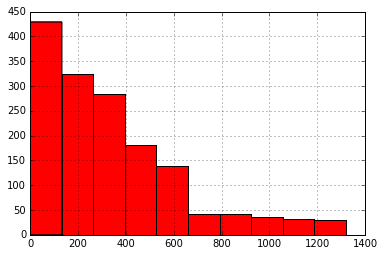

In [25]:
dates_distMat['dist2'].hist()
plt.show()

## cardio126:

### generate table with months and weeks

In [137]:
dates_cardio=pd.read_excel('%s/TCR_real_data/CardioSamples/phenotypicData/TimeToBlood2_Manual.xlsx' %MyPath).set_index('BD')
dates_cardio=pd.DataFrame(dates_cardio['Admission Date'].dropna())
dates_cardio['Admission Date']==pd.to_datetime(dates_cardio['Admission Date'])

dates_cardio.head(5)

,Admission Date
BD,
BD950,2017-02-17
BD951,2017-02-21
BD952,2017-02-22
BD953,2017-02-26
BD955,2017-03-03


In [138]:
dates_cardio['Month']=dates_cardio['Admission Date'].apply(lambda x: x.month).astype(int)
dates_cardio['Year']=dates_cardio['Admission Date'].apply(lambda x: x.year).astype(int)
dates_cardio['Season']=dates_cardio['Month'].map({1:'winter',2:'winter',12:'winter',3:'spring',4:'spring',5:'spring',
                                    6:'summer',7:'summer',8:'summer',9:'automn',4:'automn',5:'automn'})
dates_cardio['Month_year']=dates_cardio[['Month','Year']].astype(str).apply(lambda x: '_'.join(x), axis=1)
dates_cardio['Season_year']=dates_cardio[['Season','Year']].astype(str).apply(lambda x: '_'.join(x), axis=1)
dates_cardio=dates_cardio[dates_cardio['Year']!=1990]
dates_cardio=dates_cardio.dropna()
# dates_cardio[week]
print dates_cardio.shape

dates_cardio.to_excel(SEASON_DIR+'Admissiondates_cardio_PNP530.xlsx')
dates_cardio.head()

# for col in dates_cardio.columns:
#     print dates_cardio[col].value_counts(dropna=False)

(97, 6)


,Admission Date,Month,Year,Season,Month_year,Season_year
BD,,,,,,
BD950,2017-02-17,2,2017,winter,2_2017,winter_2017
BD951,2017-02-21,2,2017,winter,2_2017,winter_2017
BD952,2017-02-22,2,2017,winter,2_2017,winter_2017
BD953,2017-02-26,2,2017,winter,2_2017,winter_2017
BD955,2017-03-03,3,2017,spring,3_2017,spring_2017


In [135]:
dates_cardio['Admission Date'].dtype

dtype('<M8[ns]')

In [139]:
for col in dates_cardio.columns[1:]:
    print col
    print dates_cardio[col].value_counts(dropna=False)
    
    print ''

Month
9     18
7     13
6     13
5     12
4     11
12     8
3      8
1      7
2      4
8      3
Name: Month, dtype: int64

Year
2017    89
2018     8
Name: Year, dtype: int64

Season
automn    41
summer    29
winter    19
spring     8
Name: Season, dtype: int64

Month_year
9_2017     18
6_2017     13
7_2017     12
5_2017     11
4_2017     10
12_2017     8
3_2017      8
1_2018      5
2_2017      4
8_2017      3
1_2017      2
5_2018      1
7_2018      1
4_2018      1
Name: Month_year, dtype: int64

Season_year
automn_2017    39
summer_2017    28
winter_2017    14
spring_2017     8
winter_2018     5
automn_2018     2
summer_2018     1
Name: Season_year, dtype: int64



### generate table with dummy varaibles as target

In [141]:
dates_cardio2=dates_cardio.iloc[:,1:]
print dates_cardio2.shape
print dates_cardio2.head()
print dates_cardio2.columns
dates_targets_cardio=pd.get_dummies(dates_cardio2, columns=dates_cardio2.columns,prefix=dates_cardio2.columns)
dates_targets_cardio=dates_targets_cardio.loc[:,dates_targets_cardio.sum()[dates_targets_cardio.sum()>6].index.tolist()]
print dates_targets_cardio.shape
dates_targets_cardio.index=dates_targets_cardio.index.rename('BD')
dates_targets_cardio.to_excel(SEASON_DIR+'dates_targets_cardio.xlsx')
dates_targets_cardio.head()


(97, 5)
       Month  Year  Season Month_year  Season_year
BD                                                
BD950      2  2017  winter     2_2017  winter_2017
BD951      2  2017  winter     2_2017  winter_2017
BD952      2  2017  winter     2_2017  winter_2017
BD953      2  2017  winter     2_2017  winter_2017
BD955      3  2017  spring     3_2017  spring_2017
Index([u'Month', u'Year', u'Season', u'Month_year', u'Season_year'], dtype='object')
(97, 25)


,Month_1,Month_3,Month_4,Month_5,Month_6,Month_7,Month_9,Month_12,Year_2017,Year_2018,...,Month_year_3_2017,Month_year_4_2017,Month_year_5_2017,Month_year_6_2017,Month_year_7_2017,Month_year_9_2017,Season_year_automn_2017,Season_year_spring_2017,Season_year_summer_2017,Season_year_winter_2017
BD,,,,,,,,,,,,,,,,,,,,,
BD950,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
BD951,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
BD952,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
BD953,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
BD955,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0


(439, 34)


In [127]:
#check filtering: expect no results here:
for col in dates_targets.columns:
    if dates_targets[col].sum()<20: print col

### generate distance table in days

In [28]:
dates_cardio.loc['BD950','Admission Date']-dates_cardio.loc['BD951','Admission Date']

Timedelta('-4 days +00:00:00')

In [29]:
dates_cardio_distMat=pd.DataFrame()
count=0
for i in range(len(dates_cardio)):
    if i%10==0: print i
    for j in range(i+1,len(dates_cardio)):
        dates_cardio_distMat.loc[count,'Sample1']=dates_cardio.index[i]
        dates_cardio_distMat.loc[count,'Sample2']=dates_cardio.index[j]
        dates_cardio_distMat.loc[count,'dist']=dates_cardio.loc[dates_cardio.index[i],'Admission Date']-dates_cardio.loc[dates_cardio.index[j],'Admission Date']
        
        count=count+1
        
dates_cardio_distMat['dist2']=np.abs(dates_cardio_distMat['dist'] / np.timedelta64(1, 'D'))
dates_cardio_distMat 

0
10
20
30
40
50
60
70
80
90
100
110
120


,Sample1,Sample2,dist,dist2
0,BD950,BD951,-4 days,4.0
1,BD950,BD952,-5 days,5.0
2,BD950,BD953,-9 days,9.0
3,BD950,BD955,-14 days,14.0
4,BD950,BD956,-34 days,34.0
5,BD950,BD957,-35 days,35.0
6,BD950,BD958,-36 days,36.0
7,BD950,BD959,-34 days,34.0
8,BD950,BD960,-39 days,39.0
9,BD950,BD961,-41 days,41.0


In [33]:
dates_cardio_distMat.to_pickle(SEASON_DIR+'dates_distMat_Cardio126.dat')

In [34]:
dates_cardio_distMat_balanced=dates_cardio_distMat[(dates_cardio_distMat['Sample1'].isin(Cardio126_balanced))&(dates_cardio_distMat['Sample2'].isin(Cardio126_balanced))]
print dates_cardio_distMat_balanced.shape

(4278, 4)


In [35]:
dates_cardio_distMat_balanced.to_pickle(SEASON_DIR+'dates_distMat_Cardio126_balancedOldMales.dat')

# generate jaccard distance matrix

In [69]:
clusterDF=pd.read_pickle('/net/mraid08/export/jafar/Microbiome/Analyses/TCR/TCR_seqs_clusters/newX_onlySeqs_025_085_noNans.dat')
print clusterDF.shape
clusterDF.head()

(656, 49494)


,CASSVTSGSSYEQYF,CASRREYEQYF,CASTSYEQYF,CASSPAQSYEQYF,CASSGYGTEAFF,CASSYGGESYEQYF,CASSLRPQETQYF,CASSPGTSGGEQYF,CASSSQGLNTGELFF,CASSPPGNYEQYF,...,CASSEGPNTEAFF,CASSLGPNTEAFF,CASSLVENTEAFF,CASSLGGNTEAFF,CASSLAGGSYNEQFF,CASSLTENTEAFF,CASSPTGNTEAFF,CASSRDQETQYF,CASSLGQQETQYF,CASSDSSGSTDTQYF
BD1,0.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,2.0,2.0,...,1.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0
BD10,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,...,1.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
BD1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
BD1001,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
BD1002,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
clusterDF_binary=(clusterDF>0).astype(int)

## PNP530

In [71]:
clusterDF_binary_PNP530=clusterDF_binary.loc[PNP530,:]
print clusterDF_binary_PNP530.shape
clusterDF_binary_PNP530.head()

(530, 49494)


,CASSVTSGSSYEQYF,CASRREYEQYF,CASTSYEQYF,CASSPAQSYEQYF,CASSGYGTEAFF,CASSYGGESYEQYF,CASSLRPQETQYF,CASSPGTSGGEQYF,CASSSQGLNTGELFF,CASSPPGNYEQYF,...,CASSEGPNTEAFF,CASSLGPNTEAFF,CASSLVENTEAFF,CASSLGGNTEAFF,CASSLAGGSYNEQFF,CASSLTENTEAFF,CASSPTGNTEAFF,CASSRDQETQYF,CASSLGQQETQYF,CASSDSSGSTDTQYF
BD406,1,0,0,0,0,1,0,0,0,1,...,0,1,1,1,0,1,0,0,1,0
BD228,1,0,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
BD714,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BD808,0,0,1,0,0,1,1,0,0,0,...,1,1,0,0,0,0,0,0,1,0
BD144,0,0,0,1,0,1,1,0,0,1,...,1,1,1,1,0,1,0,0,1,0


In [72]:
df=clusterDF_binary_PNP530
metric='jaccard'
generateSquareform=False

clusterDF_jaccard_distMat_PNP530,sqaure=genDistMat(df, metric,generateSquareform)

generating condensed distance matrix using jaccard
top similar pairs:
           dist sample1 sample2
27271  0.312862   BD146    BD13
27362  0.313435   BD146   BD136
27238  0.316378   BD146   BD160
27508  0.341261   BD146   BD151
13958  0.361458   BD145   BD146
15956  0.363781   BD917   BD146
27519  0.376947   BD146    BD49
27530  0.384151   BD146   BD153
27404  0.384815   BD146   BD113
82984  0.392013    BD13   BD136


In [73]:
clusterDF_jaccard_distMat_PNP530.to_pickle(SEASON_DIR+'clusterDF_jaccard_distMat_PNP530.dat')

In [74]:
clusterDF_jaccard_distMat_PNP530balancedOldMales=clusterDF_jaccard_distMat_PNP530[(clusterDF_jaccard_distMat_PNP530['sample1'].isin(PNP530_balanced))&(clusterDF_jaccard_distMat_PNP530['sample2'].isin(PNP530_balanced))]
print clusterDF_jaccard_distMat_PNP530balancedOldMales.shape
print clusterDF_jaccard_distMat_PNP530balancedOldMales.head()
clusterDF_jaccard_distMat_PNP530balancedOldMales.to_pickle(SEASON_DIR+'clusterDF_jaccard_distMat_PNP530balancedOldMales.dat')

(1596, 3)
          dist sample1 sample2
5769  0.697492   BD801   BD221
5778  0.815069   BD801   BD631
5788  0.752968   BD801   BD441
5795  0.735471   BD801   BD834
5797  0.649588   BD801    BD27


In [75]:
clusterDF_jaccard_distMat_PNP530balancedOldMales.sort_values(by='dist').head(20)

,dist,sample1,sample2
23094,0.520771,BD27,BD124
23140,0.557377,BD27,BD106
119320,0.560564,BD124,BD106
23191,0.566657,BD27,BD150
23006,0.578605,BD27,BD935
22863,0.584674,BD27,BD859
119371,0.586664,BD124,BD150
97494,0.591092,BD935,BD124
23041,0.593228,BD27,BD909
23009,0.594492,BD27,BD369


In [76]:
clusterDF_jaccard_distMat_PNP530balancedOldMales.sort_values(by='dist').tail(20)

,dist,sample1,sample2
133470,0.896848,BD828,BD582
123434,0.897053,BD380,BD453
13834,0.897389,BD631,BD453
99648,0.897631,BD591,BD537
96131,0.898045,BD579,BD453
96722,0.898920,BD811,BD453
58681,0.899675,BD649,BD453
99670,0.900117,BD591,BD582
126059,0.901857,BD671,BD453
118195,0.901901,BD484,BD582


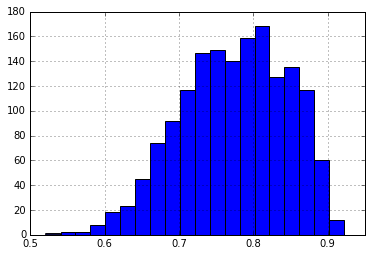

In [77]:

clusterDF_jaccard_distMat_PNP530balancedOldMales['dist'].hist(bins=20)
plt.show()

## Cardio126

In [78]:
clusterDF_binary_Cardio126=clusterDF_binary.loc[Cardio126,:]
print clusterDF_binary_Cardio126.shape
clusterDF_binary_Cardio126.head()

(126, 49494)


,CASSVTSGSSYEQYF,CASRREYEQYF,CASTSYEQYF,CASSPAQSYEQYF,CASSGYGTEAFF,CASSYGGESYEQYF,CASSLRPQETQYF,CASSPGTSGGEQYF,CASSSQGLNTGELFF,CASSPPGNYEQYF,...,CASSEGPNTEAFF,CASSLGPNTEAFF,CASSLVENTEAFF,CASSLGGNTEAFF,CASSLAGGSYNEQFF,CASSLTENTEAFF,CASSPTGNTEAFF,CASSRDQETQYF,CASSLGQQETQYF,CASSDSSGSTDTQYF
BD1014,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
BD1068,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
BD1013,1,0,1,1,0,0,0,0,0,1,...,0,1,0,1,0,0,0,1,0,1
BD1061,0,1,0,0,1,0,1,0,0,1,...,0,1,0,1,1,0,0,0,0,0
BD1066,1,0,1,0,0,0,1,1,0,1,...,0,0,1,0,1,1,0,0,0,1


In [79]:
df=clusterDF_binary_Cardio126
metric='jaccard'
generateSquareform=False

clusterDF_jaccard_distMat_Cardio126,sqaure=genDistMat(df, metric,generateSquareform)

generating condensed distance matrix using jaccard
top similar pairs:
          dist sample1 sample2
4234  0.554479  BD1083  BD1092
4278  0.579187  BD1083   BD984
3799  0.585227   BD990  BD1092
5428  0.589620  BD1092  BD1099
2011  0.594207  BD1037  BD1083
3784  0.595685   BD990  BD1083
5427  0.598794  BD1092  BD1011
4273  0.599603  BD1083  BD1099
4272  0.599653  BD1083  BD1011
4303  0.603103  BD1083  BD1081


In [80]:
clusterDF_jaccard_distMat_Cardio126.to_pickle(SEASON_DIR+'clusterDF_jaccard_distMat_NP530.dat')

In [82]:
clusterDF_jaccard_distMat_Cardio126balancedOldMales=clusterDF_jaccard_distMat_Cardio126[(clusterDF_jaccard_distMat_Cardio126['sample1'].isin(Cardio126_balanced))&(clusterDF_jaccard_distMat_Cardio126['sample2'].isin(Cardio126_balanced))]
clusterDF_jaccard_distMat_Cardio126balancedOldMales.to_pickle(SEASON_DIR+'clusterDF_jaccard_distMat_Cardio126balancedOldMales.dat')

# generate pairwise-sharing matrix

In [142]:
clusterDF=pd.read_pickle('/net/mraid08/export/jafar/Microbiome/Analyses/TCR/TCR_seqs_clusters/newX_onlySeqs_025_085_noNans.dat')
print clusterDF.shape
clusterDF.head()

(656, 49494)


,CASSVTSGSSYEQYF,CASRREYEQYF,CASTSYEQYF,CASSPAQSYEQYF,CASSGYGTEAFF,CASSYGGESYEQYF,CASSLRPQETQYF,CASSPGTSGGEQYF,CASSSQGLNTGELFF,CASSPPGNYEQYF,...,CASSEGPNTEAFF,CASSLGPNTEAFF,CASSLVENTEAFF,CASSLGGNTEAFF,CASSLAGGSYNEQFF,CASSLTENTEAFF,CASSPTGNTEAFF,CASSRDQETQYF,CASSLGQQETQYF,CASSDSSGSTDTQYF
BD1,0.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,2.0,2.0,...,1.0,2.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0
BD10,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,...,1.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0
BD1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
BD1001,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
BD1002,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [166]:
clusterDF_binary=(clusterDF>0).astype(int)
clusterDF_binary

,CASSVTSGSSYEQYF,CASRREYEQYF,CASTSYEQYF,CASSPAQSYEQYF,CASSGYGTEAFF,CASSYGGESYEQYF,CASSLRPQETQYF,CASSPGTSGGEQYF,CASSSQGLNTGELFF,CASSPPGNYEQYF,...,CASSEGPNTEAFF,CASSLGPNTEAFF,CASSLVENTEAFF,CASSLGGNTEAFF,CASSLAGGSYNEQFF,CASSLTENTEAFF,CASSPTGNTEAFF,CASSRDQETQYF,CASSLGQQETQYF,CASSDSSGSTDTQYF
BD1,0,0,1,1,1,0,1,0,1,1,...,1,1,1,1,0,0,1,0,1,0
BD10,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,1,0,0,0
BD1000,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
BD1001,0,0,1,1,1,1,0,0,0,0,...,0,1,0,1,0,1,0,1,0,0
BD1002,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
BD1003,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
BD1004,0,0,0,0,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,1,0
BD1005,0,0,0,0,0,0,1,0,0,1,...,0,1,0,1,1,0,0,1,1,0
BD1006,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,1,0,1
BD1007,0,1,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


## PNP530

In [71]:
clusterDF_binary_PNP530=clusterDF_binary.loc[PNP530,:]
print clusterDF_binary_PNP530.shape
clusterDF_binary_PNP530.head()

(530, 49494)


,CASSVTSGSSYEQYF,CASRREYEQYF,CASTSYEQYF,CASSPAQSYEQYF,CASSGYGTEAFF,CASSYGGESYEQYF,CASSLRPQETQYF,CASSPGTSGGEQYF,CASSSQGLNTGELFF,CASSPPGNYEQYF,...,CASSEGPNTEAFF,CASSLGPNTEAFF,CASSLVENTEAFF,CASSLGGNTEAFF,CASSLAGGSYNEQFF,CASSLTENTEAFF,CASSPTGNTEAFF,CASSRDQETQYF,CASSLGQQETQYF,CASSDSSGSTDTQYF
BD406,1,0,0,0,0,1,0,0,0,1,...,0,1,1,1,0,1,0,0,1,0
BD228,1,0,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
BD714,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BD808,0,0,1,0,0,1,1,0,0,0,...,1,1,0,0,0,0,0,0,1,0
BD144,0,0,0,1,0,1,1,0,0,1,...,1,1,1,1,0,1,0,0,1,0


In [148]:
clusterDF_binary=clusterDF_binary_PNP530


sharing_simMatrix=pd.DataFrame()
count=0
for i in range(len(clusterDF_binary)):
    if i%10==0:print i
    for j in range(i+1,len(clusterDF_binary)):
        sharing_simMatrix.loc[count,'Sample1']=clusterDF_binary.index[i]
        sharing_simMatrix.loc[count,'Sample2']=clusterDF_binary.index[j]
        sharing_sum=clusterDF_binary.iloc[[i,j],:].sum()
        identical_num=len(sharing_sum[sharing_sum==2])
        sharing_simMatrix.loc[count,'sharing']=identical_num
        
        count=count+1
        
sharing_simMatrix

            

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520


,Sample1,Sample2,sharing
0,BD406,BD228,6276.0
1,BD406,BD714,5426.0
2,BD406,BD808,8235.0
3,BD406,BD144,7972.0
4,BD406,BD617,5006.0
5,BD406,BD143,5231.0
6,BD406,BD195,7416.0
7,BD406,BD673,2871.0
8,BD406,BD401,6508.0
9,BD406,BD377,6268.0


In [156]:
sharing_simMatrix.to_pickle(SEASON_DIR+'sharing_simMatrix_PNP530.dat')

In [158]:
sharing_simMatrixbalancedOldMales_PNP530=sharing_simMatrix[(sharing_simMatrix['Sample1'].isin(PNP530_balanced))&(sharing_simMatrix['Sample2'].isin(PNP530_balanced))]
print sharing_simMatrixbalancedOldMales_PNP530.shape
print sharing_simMatrixbalancedOldMales_PNP530.head()
sharing_simMatrixbalancedOldMales_PNP530.to_pickle(SEASON_DIR+'sharing_simMatrixbalancedOldMales_PNP530.dat')

(1596, 3)
     Sample1 Sample2  sharing
5769   BD801   BD221   9964.0
5778   BD801   BD631   4710.0
5788   BD801   BD441   7178.0
5795   BD801   BD834   7911.0
5797   BD801    BD27  13350.0


In [161]:
sharing_simMatrixbalancedOldMales_PNP530.sort_values(by='sharing').head(20)

,Sample1,Sample2,sharing
135484,BD453,BD582,948.0
137995,BD537,BD582,1012.0
135462,BD453,BD537,1041.0
99617,BD591,BD453,1072.0
124156,BD640,BD453,1082.0
124209,BD640,BD582,1235.0
133417,BD828,BD453,1241.0
88084,BD66,BD453,1280.0
127207,BD398,BD453,1341.0
99670,BD591,BD582,1368.0


In [163]:
sharing_simMatrixbalancedOldMales_PNP530.sort_values(by='sharing').tail(20)

,Sample1,Sample2,sharing
22838,BD27,BD908,14980.0
22963,BD27,BD149,15041.0
119353,BD124,BD19,15137.0
22920,BD27,BD574,15239.0
98364,BD369,BD124,15330.0
45585,BD859,BD124,15411.0
23285,BD27,BD442,15473.0
22904,BD27,BD865,15625.0
8884,BD221,BD27,15648.0
97494,BD935,BD124,15790.0


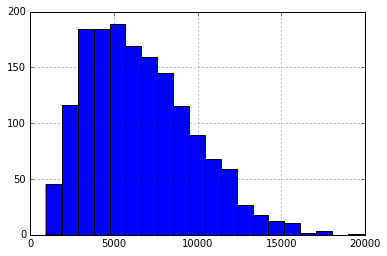

In [164]:

sharing_simMatrixbalancedOldMales_PNP530['sharing'].hist(bins=20)
plt.show()

## Cardio126

In [167]:
clusterDF_binary_Cardio126=clusterDF_binary.loc[Cardio126,:]
print clusterDF_binary_Cardio126.shape
clusterDF_binary_Cardio126.head()

(126, 49494)


,CASSVTSGSSYEQYF,CASRREYEQYF,CASTSYEQYF,CASSPAQSYEQYF,CASSGYGTEAFF,CASSYGGESYEQYF,CASSLRPQETQYF,CASSPGTSGGEQYF,CASSSQGLNTGELFF,CASSPPGNYEQYF,...,CASSEGPNTEAFF,CASSLGPNTEAFF,CASSLVENTEAFF,CASSLGGNTEAFF,CASSLAGGSYNEQFF,CASSLTENTEAFF,CASSPTGNTEAFF,CASSRDQETQYF,CASSLGQQETQYF,CASSDSSGSTDTQYF
BD1014,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
BD1068,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
BD1013,1,0,1,1,0,0,0,0,0,1,...,0,1,0,1,0,0,0,1,0,1
BD1061,0,1,0,0,1,0,1,0,0,1,...,0,1,0,1,1,0,0,0,0,0
BD1066,1,0,1,0,0,0,1,1,0,1,...,0,0,1,0,1,1,0,0,0,1


In [168]:
clusterDF_binary=clusterDF_binary_Cardio126


sharing_simMatrix_cardio=pd.DataFrame()
count=0
for i in range(len(clusterDF_binary)):
    if i%10==0:print i
    for j in range(i+1,len(clusterDF_binary)):
        sharing_simMatrix_cardio.loc[count,'Sample1']=clusterDF_binary.index[i]
        sharing_simMatrix_cardio.loc[count,'Sample2']=clusterDF_binary.index[j]
        sharing_sum=clusterDF_binary.iloc[[i,j],:].sum()
        identical_num=len(sharing_sum[sharing_sum==2])
        sharing_simMatrix_cardio.loc[count,'sharing']=identical_num
        
        count=count+1
        
sharing_simMatrix_cardio

            

0
10
20
30
40
50
60
70
80
90
100
110
120


,Sample1,Sample2,sharing
0,BD1014,BD1068,984.0
1,BD1014,BD1013,1177.0
2,BD1014,BD1061,1250.0
3,BD1014,BD1066,1849.0
4,BD1014,BD996,1640.0
5,BD1014,BD1053,2155.0
6,BD1014,BD1082,1532.0
7,BD1014,BD991,495.0
8,BD1014,BD1054,1490.0
9,BD1014,BD1028,1359.0


In [169]:
sharing_simMatrix_cardio.to_pickle(SEASON_DIR+'sharing_simMatrix_Cardio126.dat')

In [178]:
sharing_simMatrix_cardiobalancedOldMales=sharing_simMatrix_cardio[(sharing_simMatrix_cardio['Sample1'].isin(Cardio126_balanced))&(sharing_simMatrix_cardio['Sample2'].isin(Cardio126_balanced))]
print sharing_simMatrix_cardiobalancedOldMales.shape
print sharing_simMatrix_cardiobalancedOldMales.head()
sharing_simMatrix_cardiobalancedOldMales.to_pickle(SEASON_DIR+'sharing_simMatrix_cardiobalancedOldMales.dat')

(4278, 3)
  Sample1 Sample2  sharing
0  BD1014  BD1068    984.0
2  BD1014  BD1061   1250.0
4  BD1014   BD996   1640.0
5  BD1014  BD1053   2155.0
6  BD1014  BD1082   1532.0


In [180]:
sharing_simMatrix_cardiobalancedOldMales.sort_values(by='sharing').head(20)

,Sample1,Sample2,sharing
73,BD1014,BD953,468.0
7,BD1014,BD991,495.0
63,BD1014,BD968,505.0
56,BD1014,BD957,546.0
5993,BD968,BD953,579.0
5545,BD957,BD953,611.0
99,BD1014,BD955,615.0
1037,BD991,BD953,636.0
1063,BD991,BD955,643.0
6574,BD953,BD955,645.0


In [181]:
sharing_simMatrix_cardiobalancedOldMales.sort_values(by='sharing').tail(20)

,Sample1,Sample2,sharing
5286,BD1076,BD1011,13034.0
2070,BD1037,BD984,13052.0
5287,BD1076,BD1099,13071.0
7548,BD984,BD1081,13167.0
2065,BD1037,BD1099,13183.0
7352,BD1011,BD984,13240.0
7408,BD1099,BD1081,13290.0
7383,BD1099,BD984,13455.0
4280,BD1083,BD1097,13463.0
1573,BD998,BD1083,13609.0


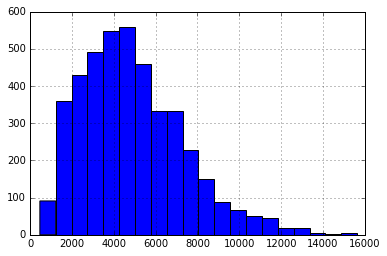

In [182]:

sharing_simMatrix_cardiobalancedOldMales['sharing'].hist(bins=20)
plt.show()

# calculate associations between date distances and TCRdf distances:

## PNP530:

### GET DATA:

(1540, 4)
       Sample1 Sample2      dist  days_dist
127147  BD101   BD150  35 days    35.0     
127129  BD101   BD19   -112 days  112.0    
127151  BD101   BD273  -168 days  168.0    
127240  BD101   BD442  -293 days  293.0    
127157  BD101   BD453  -333 days  333.0    


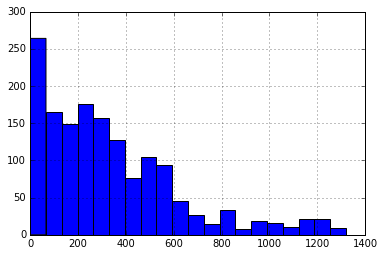

In [232]:
#days distmat:
dates_distMat_balancedPNP530=pd.read_pickle(SEASON_DIR+'dates_distMat_PNP530_balancedOldMales.dat')
dates_distMat_balancedPNP530=dates_distMat_balancedPNP530.sort_values(by=['Sample1','Sample2'])
dates_distMat_balancedPNP530=dates_distMat_balancedPNP530.rename(columns={'dist2':'days_dist'})
print dates_distMat_balancedPNP530.shape
print dates_distMat_balancedPNP530.head()
dates_distMat_balancedPNP530['days_dist'].hist(bins=20)
plt.show()


       Sample1 Sample2  sharing
129637  BD101   BD150   6565.0 
129619  BD101   BD19    6451.0 
129641  BD101   BD273   5441.0 
129731  BD101   BD442   6189.0 
129647  BD101   BD453   1717.0 


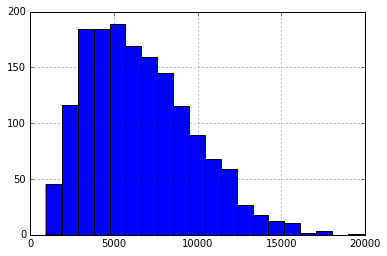

In [231]:
# sharing:
sharing_simMatrixbalancedOldMales_PNP530=pd.read_pickle(SEASON_DIR+'sharing_simMatrixbalancedOldMales_PNP530.dat')
sharing_simMatrixbalancedOldMales_PNP530=sharing_simMatrixbalancedOldMales_PNP530.sort_values(by=['Sample1','Sample2'])
# sharing_simMatrixbalancedOldMales_PNP530=sharing_simMatrixbalancedOldMales_PNP530.rename(columns={'dist2':'days_dist'})
sharing_simMatrixbalancedOldMales_PNP530.shape
print sharing_simMatrixbalancedOldMales_PNP530.head()
sharing_simMatrixbalancedOldMales_PNP530['sharing'].hist(bins=20)
plt.show()

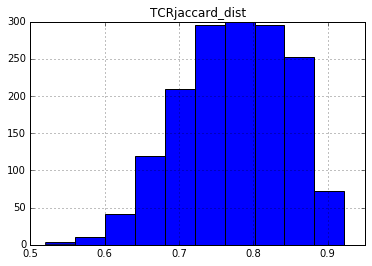

In [39]:
#jaccard:
clusterDF_jaccard_distMat_PNP530balancedOldMales=pd.read_pickle(SEASON_DIR+'clusterDF_jaccard_distMat_PNP530balancedOldMales.dat')
# clusterDF_jaccard_distMat_PNP530balancedOldMales=clusterDF_jaccard_distMat_PNP530balancedOldMales.sort_values(by=['sample1','sample2'])
clusterDF_jaccard_distMat_PNP530balancedOldMales=clusterDF_jaccard_distMat_PNP530balancedOldMales.rename(columns={'dist':'TCRjaccard_dist'})
print clusterDF_jaccard_distMat_PNP530balancedOldMales.shape
print clusterDF_jaccard_distMat_PNP530balancedOldMales.head()
clusterDF_jaccard_distMat_PNP530balancedOldMales.hist()
plt.show()

In [40]:
merged_PNP530=pd.merge(dates_distMat_balancedPNP530,clusterDF_jaccard_distMat_PNP530balancedOldMales,how='inner',left_on=('Sample1','Sample2'),right_on=('sample1','sample2'))
print merged_PNP530.shape
merged_PNP530.head()

(1540, 7)


,Sample1,Sample2,dist,days_dist,TCRjaccard_dist,sample1,sample2
0,BD101,BD150,35 days,35.0,0.782738,BD101,BD150
1,BD101,BD19,-112 days,112.0,0.779634,BD101,BD19
2,BD101,BD273,-168 days,168.0,0.799010,BD101,BD273
3,BD101,BD442,-293 days,293.0,0.783184,BD101,BD442
4,BD101,BD453,-333 days,333.0,0.892587,BD101,BD453


In [235]:
merged_PNP530_2=pd.merge(dates_distMat_balancedPNP530,sharing_simMatrixbalancedOldMales_PNP530,how='inner',left_on=('Sample1','Sample2'),right_on=('Sample1','Sample2'))
print merged_PNP530_2.shape
merged_PNP530_2.head()

(1540, 5)


,Sample1,Sample2,dist,days_dist,sharing
0,BD101,BD150,35 days,35.0,6565.0
1,BD101,BD19,-112 days,112.0,6451.0
2,BD101,BD273,-168 days,168.0,5441.0
3,BD101,BD442,-293 days,293.0,6189.0
4,BD101,BD453,-333 days,333.0,1717.0


### correlation:

In [437]:
def plot_corr_days_TCR_dist(mergedDF, TCR_dist_col,max_days_diff,max_TCR_dist,title,ax):
    
    mergedDF=mergedDF[mergedDF['days_dist']<max_days_diff]
    mergedDF=mergedDF[mergedDF[TCR_dist_col]<max_TCR_dist]
    mergedDF['new_index']=range(len(mergedDF))
    mergedDF=mergedDF.set_index('new_index')
    print mergedDF.shape
    print mergedDF.head()
    
    r,p=MyPearsonr(mergedDF['days_dist'],mergedDF[TCR_dist_col])
    print r,p
    
    data1=mergedDF['days_dist']
    data2=mergedDF[TCR_dist_col]
    data1name='Days Distance'
    data2name='TCR seq. distance (%s)'%TCR_dist_col



    ax, nsamples,r,p,text, handles, labels=plot_corr(data1,data2,data1name,data2name,ax,title,corrType='pearson',
                  toAnnotate=True,plotTrendLine=True,scatter_kws={'alpha':0.4,'s':100},
                   text_kws={'fontsize':'x-large'},linecolor='black')
   
    return ax

    
    

#### all

(1540, 6)
          Sample1 Sample2      dist  days_dist  sharing Binned_days_dist
new_index                                                               
0          BD101   BD150  35 days    35.0       6565.0   upTo0.5year    
1          BD101   BD19   -112 days  112.0      6451.0   upTo0.5year    
2          BD101   BD273  -168 days  168.0      5441.0   upTo0.5year    
3          BD101   BD442  -293 days  293.0      6189.0   0.5to1year     
4          BD101   BD453  -333 days  333.0      1717.0   0.5to1year     
-0.021455063101491 0.400140319745964
1540
1540


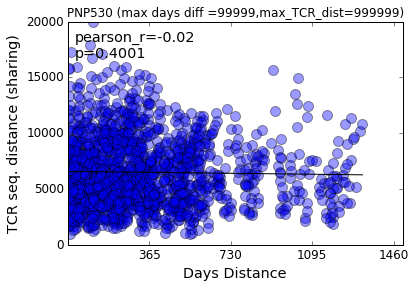

In [439]:
mergedDF=merged_PNP530_2
TCR_dist_col='sharing'
max_days_diff=99999
max_TCR_dist=999999
title='PNP530 (max days diff =%s,max_TCR_dist=%s)' %(max_days_diff,max_TCR_dist)

fig,ax=plt.subplots()
ax=plot_corr_days_TCR_dist(mergedDF, TCR_dist_col,max_days_diff,max_TCR_dist,title,ax)
ax.set_xlim(0,1500)
ax.set_ylim(0,20000)
xticks=[x*365 for x in range(1,5)]
ax.set_xticks(xticks)
plt.show()

fig.savefig('%s/TCR_real_data/seasonality/analysis/days_dist_sharing_correlation_PNP530.png' %MyPath,bbox_inches = "tight")

### compare distribution of day dists between different sharing levels

In [252]:
quant_list=[0.05,0.475,0.525,0.95]


low_sharing=merged_PNP530_2[merged_PNP530_2['sharing']<merged_PNP530_2['sharing'].quantile(quant_list[0])]
medium_sharing=merged_PNP530_2[(merged_PNP530_2['sharing']>merged_PNP530_2['sharing'].quantile(quant_list[1]))&
                              (merged_PNP530_2['sharing']<merged_PNP530_2['sharing'].quantile(quant_list[2]))]
high_sharing=merged_PNP530_2[merged_PNP530_2['sharing']>merged_PNP530_2['sharing'].quantile(quant_list[3])]

generating kde plot
generating kde plot
generating kde plot


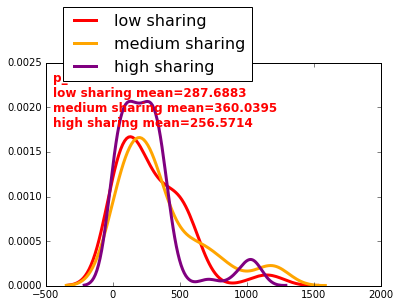

In [253]:
dataList=[('low sharing',low_sharing['days_dist'].tolist()),
          ('medium sharing',medium_sharing['days_dist'].tolist()),
          ('high sharing',high_sharing['days_dist'].tolist()),
         
         ]

fig,ax=plt.subplots()
title=''

plotHistComprison(dataList,ax,title,showLegend=True,nBins=20,toAnnotate=True,
                      colorList=['red','orange','purple'],alpha=None,
                      text_kws={'fontsize':'large','fontweight':'bold','color':'red',
                                'horizontalalignment':'left','verticalalignment':'top'},
                      plotType='kde')

plt.show()

### compare sharing distributions for pairs with different admission date differences

generating kde plot
generating kde plot
generating kde plot
generating kde plot


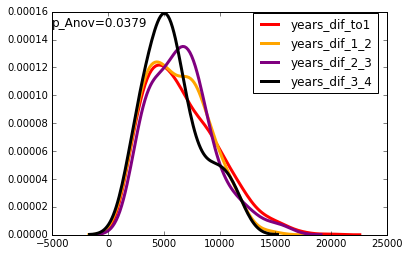

In [441]:
years_dif_to1=merged_PNP530_2[merged_PNP530_2['days_dist']<=365]
years_dif_1_2=merged_PNP530_2[(merged_PNP530_2['days_dist']>365)&(merged_PNP530_2['days_dist']<=730)]
years_dif_2_3=merged_PNP530_2[(merged_PNP530_2['days_dist']>730)&(merged_PNP530_2['days_dist']<1095)]
years_dif_3_4=merged_PNP530_2[merged_PNP530_2['days_dist']>1095]

dataList=[('years_dif_to1',years_dif_to1['sharing'].tolist()),
          ('years_dif_1_2',years_dif_1_2['sharing'].tolist()),
          ('years_dif_2_3',years_dif_2_3['sharing'].tolist()),
          ('years_dif_3_4',years_dif_3_4['sharing'].tolist())
         
         
         ]
colorList=['red','orange','purple','black']
fig,ax=plt.subplots()
title=''

ax,ks_p_cohort1_cohort2,t_p_cohort1_cohort2,p_Anov,filename=plotHistComprison(dataList,ax,title,showLegend=False,nBins=20,toAnnotate=False,
                      colorList=colorList,alpha=None,
                      text_kws={'fontsize':'large','fontweight':'bold','color':'red',
                                'horizontalalignment':'left','verticalalignment':'top'},
                      plotType='kde')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels,loc='top right',bbox_to_anchor=(0.99,1.02))
ax.text(0,0.98,'p_Anov=%s' %round(p_Anov,4),ha='left',va='top',transform=ax.transAxes,fontsize='large')
fig.savefig('%s/TCR_real_data/seasonality/analysis/sharing_dist_per_admission_distance_PNP530.png' %MyPath,bbox_inches = "tight")
plt.show()

generating kde plot
generating kde plot
generating kde plot


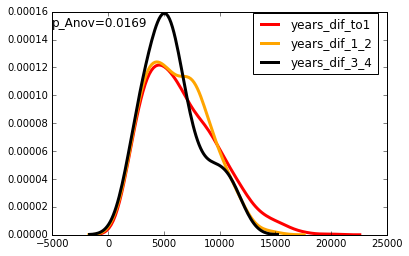

In [442]:
years_dif_to1=merged_PNP530_2[merged_PNP530_2['days_dist']<=365]
years_dif_1_2=merged_PNP530_2[(merged_PNP530_2['days_dist']>365)&(merged_PNP530_2['days_dist']<=730)]
# years_dif_2_3=merged_PNP530_2[(merged_PNP530_2['days_dist']>730)&(merged_PNP530_2['days_dist']<1095)]
years_dif_3_4=merged_PNP530_2[merged_PNP530_2['days_dist']>1095]

dataList=[('years_dif_to1',years_dif_to1['sharing'].tolist()),
          ('years_dif_1_2',years_dif_1_2['sharing'].tolist()),
#           ('years_dif_2_3',years_dif_2_3['sharing'].tolist()),
          ('years_dif_3_4',years_dif_3_4['sharing'].tolist())
         
         
         ]
colorList=['red','orange','black']
fig,ax=plt.subplots()
title=''

ax,ks_p_cohort1_cohort2,t_p_cohort1_cohort2,p_Anov,filename=plotHistComprison(dataList,ax,title,showLegend=False,nBins=20,toAnnotate=False,
                      colorList=colorList,alpha=None,
                      text_kws={'fontsize':'large','fontweight':'bold','color':'red',
                                'horizontalalignment':'left','verticalalignment':'top'},
                      plotType='kde')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels,loc='top right',bbox_to_anchor=(0.99,1.02))
ax.text(0,0.98,'p_Anov=%s' %round(p_Anov,4),ha='left',va='top',transform=ax.transAxes,fontsize='large')
fig.savefig('%s/TCR_real_data/seasonality/analysis/sharing_dist_per_admission_distance_no23years_PNP530.png' %MyPath,bbox_inches = "tight")
plt.show()

In [435]:
import scipy.stats as ss

In [432]:
def boxplot_sharing_by_daydist(dataDF,day_dist_col,sharing_col,bin_edges,bin_names,ax,title='',usePercentile=0.9):
    dataDF['Binned_days_dist']=pd.cut(dataDF[day_dist_col],bin_edges,labels=bin_names)
    print dataDF['Binned_days_dist'].value_counts()

    samples = [condition[1] for condition in dataDF.groupby('Binned_days_dist')['sharing']]
    thresholds=[condition[1].quantile(usePercentile) for condition in dataDF.groupby('Binned_days_dist')['sharing']]

    f_val1, p_val1 = ss.f_oneway(*samples)
    print('F value all: {:.3f}, p value: {:.3f}'.format(f_val1, p_val1))
    
    ax = sns.boxplot(x="Binned_days_dist", y="sharing", data=dataDF)
    ax.text(0.99,0.98,'F value: {:.3f}, p value: {:.3f}'.format(f_val1, p_val1),ha='right',
            va='top',transform=ax.transAxes,fontsize='large',color='red')
    ax.plot(range(len(bin_names)),thresholds,color='black',linewidth=2,label='%s percentile' %usePercentile)
    ax.legend(loc='lower right')
    ax.set_title(title,fontsize='x-large')
    return ax


5
4
upTo1year    975
1to2years    404
2to3years    102
3to4years    52 
Name: Binned_days_dist, dtype: int64
F value all: 2.827, p value: 0.037


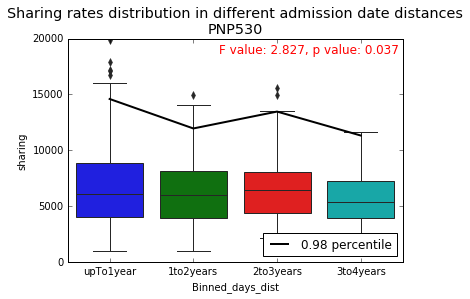

In [455]:
dataDF=merged_PNP530_2
day_dist_col='days_dist'
sharing_col='sharing'
bin_edges=[0,365,730,1095,1460]
print len(bin_edges)
bin_names=['upTo1year','1to2years','2to3years','3to4years']
print len(bin_names)
title='Sharing rates distribution in different admission date distances\nPNP530'
usePercentile=0.98

fig,ax=plt.subplots()
ax=boxplot_sharing_by_daydist(dataDF,day_dist_col,sharing_col,bin_edges,bin_names,ax,title,usePercentile)
fig.savefig('%s/TCR_real_data/seasonality/analysis/sharing_dist_per_admission_distance_PNP530_boxplot.png' %MyPath,bbox_inches = "tight")
plt.show()




upTo0.5year    542
0.5to1year     433
1to1.5years    270
1.5to2years    134
2to2.5years    56 
Name: Binned_days_dist, dtype: int64
F value all: 2.868, p value: 0.022


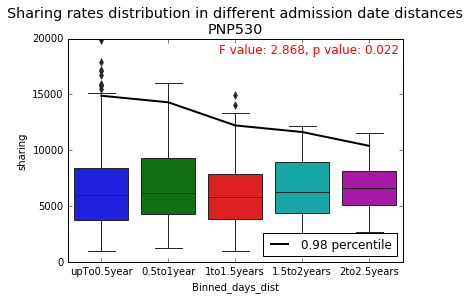

In [456]:
dataDF=merged_PNP530_2
day_dist_col='days_dist'
sharing_col='sharing'
bin_edges=[x*182.5 for x in range(0,6)]
# print len(bin_edges)
bin_names=['upTo0.5year','0.5to1year','1to1.5years','1.5to2years','2to2.5years']
# print len(bin_names)
title='Sharing rates distribution in different admission date distances\nPNP530'
usePercentile=0.98

fig,ax=plt.subplots()
ax=boxplot_sharing_by_daydist(dataDF,day_dist_col,sharing_col,bin_edges,bin_names,
                              ax,title,usePercentile)
fig.savefig('%s/TCR_real_data/seasonality/analysis/sharing_dist_per_admission_distance_PNP530_boxplot_halfyears.png' %MyPath,bbox_inches = "tight")
plt.show()




<3M       313
6-9M      236
3-6M      229
9-12M     197
15-18M    142
12-15M    128
18-21M    99 
21-24M    35 
Name: Binned_days_dist, dtype: int64
F value all: 3.170, p value: 0.002


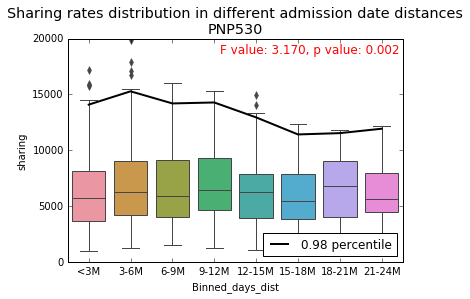

In [457]:
dataDF=merged_PNP530_2
day_dist_col='days_dist'
sharing_col='sharing'
bin_edges=[x*91 for x in range(0,9)]
# print len(bin_edges)
bin_names=['<3M','3-6M','6-9M','9-12M','12-15M','15-18M','18-21M','21-24M']
# print len(bin_names)
title='Sharing rates distribution in different admission date distances\nPNP530'
usePercentile=0.98

fig,ax=plt.subplots()
ax=boxplot_sharing_by_daydist(dataDF,day_dist_col,sharing_col,bin_edges,bin_names,
                              ax,title,usePercentile)
fig.savefig('%s/TCR_real_data/seasonality/analysis/sharing_dist_per_admission_distance_PNP530_boxplot_3M.png' %MyPath,bbox_inches = "tight")
plt.show()




In [343]:
xticks2=[x*182.5 for x in range(1,9)]
xticks2

[182.5, 365.0, 547.5, 730.0, 912.5, 1095.0, 1277.5, 1460.0]

generating kde plot
generating kde plot
generating kde plot
generating kde plot


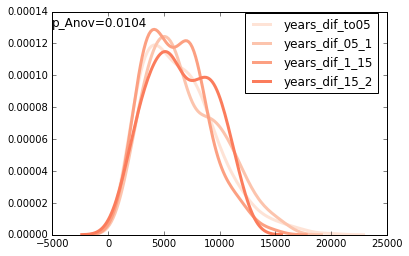

In [350]:
years_dif_to05=merged_PNP530_2[merged_PNP530_2['days_dist']<=182.5]
years_dif_05_1=merged_PNP530_2[(merged_PNP530_2['days_dist']>182.5)&(merged_PNP530_2['days_dist']<=365)]
years_dif_1_15=merged_PNP530_2[(merged_PNP530_2['days_dist']>365)&(merged_PNP530_2['days_dist']<=547.5)]
years_dif_15_2=merged_PNP530_2[(merged_PNP530_2['days_dist']>547.5)&(merged_PNP530_2['days_dist']<=730)]
# years_dif_2_25=merged_PNP530_2[(merged_PNP530_2['days_dist']>730)&(merged_PNP530_2['days_dist']<912.5)]
# years_dif_25_3=merged_PNP530_2[(merged_PNP530_2['days_dist']>912.5)&(merged_PNP530_2['days_dist']<1095)]
# years_dif_3_35=merged_PNP530_2[(merged_PNP530_2['days_dist']>1095)&(merged_PNP530_2['days_dist']<1277.5)]
# years_dif_35_4=merged_PNP530_2[merged_PNP530_2['days_dist']>1277.5]

dataList=[('years_dif_to05',years_dif_to05['sharing'].tolist()),
          ('years_dif_05_1',years_dif_05_1['sharing'].tolist()),
          ('years_dif_1_15',years_dif_1_15['sharing'].tolist()),
          ('years_dif_15_2',years_dif_15_2['sharing'].tolist()),
#            ('years_dif_2_25',years_dif_2_25['sharing'].tolist()),
#           ('years_dif_25_3',years_dif_25_3['sharing'].tolist()),
#           ('years_dif_3_35',years_dif_3_35['sharing'].tolist()),
#            ('years_dif_35_4',years_dif_35_4['sharing'].tolist())
         ]
         
colorList = sns.color_palette('Reds', n_colors=8)        
         
# colorList=['red','orange','purple','black']
fig,ax=plt.subplots()
title=''

ax,ks_p_cohort1_cohort2,t_p_cohort1_cohort2,p_Anov,filename=plotHistComprison(dataList,ax,title,showLegend=False,nBins=20,toAnnotate=False,
                      colorList=colorList,alpha=None,
                      text_kws={'fontsize':'large','fontweight':'bold','color':'red',
                                'horizontalalignment':'left','verticalalignment':'top'},
                      plotType='kde')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels,loc='top right',bbox_to_anchor=(0.99,1.02))
ax.text(0,0.98,'p_Anov=%s' %round(p_Anov,4),ha='left',va='top',transform=ax.transAxes,fontsize='large')
plt.show()

## Cardio126:

### GET DATA:

(4278, 4)
     Sample1 Sample2    dist  days_dist
4510  BD1000  BD1001 0 days   0.0      
4511  BD1000  BD1002 -2 days  2.0      
4512  BD1000  BD1003 -3 days  3.0      
4513  BD1000  BD1004 -5 days  5.0      
4514  BD1000  BD1005 -9 days  9.0      


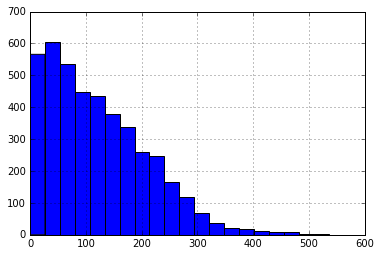

In [255]:
#days_distmat:
dates_distMat_balancedCardio126=pd.read_pickle(SEASON_DIR+'dates_distMat_Cardio126_balancedOldMales.dat')
dates_distMat_balancedCardio126=dates_distMat_balancedCardio126.sort_values(by=['Sample1','Sample2'])
dates_distMat_balancedCardio126=dates_distMat_balancedCardio126.rename(columns={'dist2':'days_dist'})
print dates_distMat_balancedCardio126.shape
print dates_distMat_balancedCardio126.head()
dates_distMat_balancedCardio126['days_dist'].hist(bins=20)
plt.show()


(4278, 3)
   TCRjaccard_dist sample1 sample2
0  0.917018         BD1014  BD1068
2  0.921997         BD1014  BD1061
4  0.905301         BD1014  BD996 
5  0.910725         BD1014  BD1053
6  0.914198         BD1014  BD1082


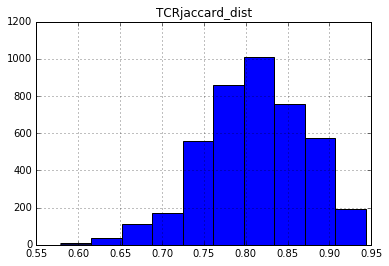

In [256]:
# jaccard:
clusterDF_jaccard_distMat_Cardio126balancedOldMales=pd.read_pickle(SEASON_DIR+'clusterDF_jaccard_distMat_Cardio126balancedOldMales.dat')
# clusterDF_jaccard_distMat_Cardio126balancedOldMales=clusterDF_jaccard_distMat_Cardio126balancedOldMales.sort_values(by=['sample1','sample2'])
clusterDF_jaccard_distMat_Cardio126balancedOldMales=clusterDF_jaccard_distMat_Cardio126balancedOldMales.rename(columns={'dist':'TCRjaccard_dist'})
print clusterDF_jaccard_distMat_Cardio126balancedOldMales.shape
print clusterDF_jaccard_distMat_Cardio126balancedOldMales.head()
clusterDF_jaccard_distMat_Cardio126balancedOldMales.hist()
plt.show()

(4278, 3)
     Sample1 Sample2  sharing
6090  BD1000  BD1001  4514.0 
6088  BD1000  BD1006  4539.0 
6092  BD1000  BD1010  2358.0 
6072  BD1000  BD1011  7891.0 
6070  BD1000  BD1016  4359.0 


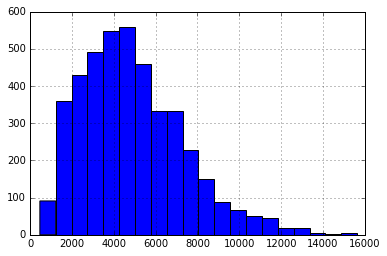

In [258]:
# sharing:
sharing_simMatrixbalancedOldMales_Cardio126=pd.read_pickle(SEASON_DIR+'sharing_simMatrix_cardiobalancedOldMales.dat')
sharing_simMatrixbalancedOldMales_Cardio126=sharing_simMatrixbalancedOldMales_Cardio126.sort_values(by=['Sample1','Sample2'])
# sharing_simMatrixbalancedOldMales_Cardio126=sharing_simMatrixbalancedOldMales_Cardio126.rename(columns={'dist2':'days_dist'})
print sharing_simMatrixbalancedOldMales_Cardio126.shape
print sharing_simMatrixbalancedOldMales_Cardio126.head()
sharing_simMatrixbalancedOldMales_Cardio126['sharing'].hist(bins=20)
plt.show()

In [90]:
merged_Cardio126=pd.merge(dates_distMat_balancedCardio126,clusterDF_jaccard_distMat_Cardio126balancedOldMales,how='inner',left_on=('Sample1','Sample2'),right_on=('sample1','sample2'))
print merged_Cardio126.shape
merged_Cardio126.head()

(2189, 7)


,Sample1,Sample2,dist,days_dist,TCRjaccard_dist,sample1,sample2
0,BD1000,BD1001,0 days,0.0,0.812073,BD1000,BD1001
1,BD1000,BD1006,79 days,79.0,0.805693,BD1000,BD1006
2,BD1000,BD1010,76 days,76.0,0.874086,BD1000,BD1010
3,BD1000,BD1011,-28 days,28.0,0.746074,BD1000,BD1011
4,BD1000,BD1016,-43 days,43.0,0.810132,BD1000,BD1016


In [259]:
merged_Cardio126_2=pd.merge(dates_distMat_balancedCardio126,sharing_simMatrixbalancedOldMales_Cardio126,how='inner',left_on=('Sample1','Sample2'),right_on=('Sample1','Sample2'))
print merged_Cardio126_2.shape
merged_Cardio126_2.head()

(2189, 5)


,Sample1,Sample2,dist,days_dist,sharing
0,BD1000,BD1001,0 days,0.0,4514.0
1,BD1000,BD1006,79 days,79.0,4539.0
2,BD1000,BD1010,76 days,76.0,2358.0
3,BD1000,BD1011,-28 days,28.0,7891.0
4,BD1000,BD1016,-43 days,43.0,4359.0


### correlation:

(2189, 5)
          Sample1 Sample2     dist  days_dist  sharing
new_index                                             
0          BD1000  BD1001 0 days    0.0        4514.0 
1          BD1000  BD1006 79 days   79.0       4539.0 
2          BD1000  BD1010 76 days   76.0       2358.0 
3          BD1000  BD1011 -28 days  28.0       7891.0 
4          BD1000  BD1016 -43 days  43.0       4359.0 
0.02454055870672929 0.25109655968806155
2189
2189


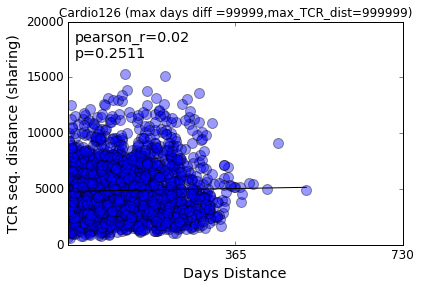

In [445]:
mergedDF=merged_Cardio126_2
TCR_dist_col='sharing'
max_days_diff=99999
max_TCR_dist=999999
title='Cardio126 (max days diff =%s,max_TCR_dist=%s)' %(max_days_diff,max_TCR_dist)

fig,ax=plt.subplots()
ax=plot_corr_days_TCR_dist(mergedDF, TCR_dist_col,max_days_diff,max_TCR_dist,title,ax)

ax.set_xlim(0,600)
ax.set_ylim(0,20000)
xticks=[x*365 for x in range(1,3)]
ax.set_xticks(xticks)
plt.show()

fig.savefig('%s/TCR_real_data/seasonality/analysis/days_dist_sharing_correlation_Cardio126.png' %MyPath,bbox_inches = "tight")



generating kde plot
generating kde plot
generating kde plot


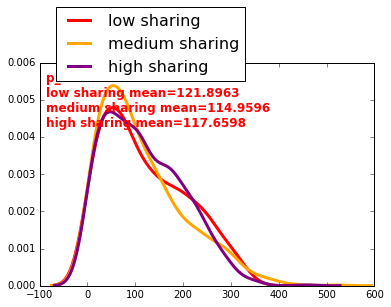

In [266]:
quant_list=[0.33,0.33,0.67,0.67]


low_sharing=merged_Cardio126_2[merged_Cardio126_2['sharing']<merged_Cardio126_2['sharing'].quantile(quant_list[0])]
medium_sharing=merged_Cardio126_2[(merged_Cardio126_2['sharing']>merged_Cardio126_2['sharing'].quantile(quant_list[1]))&
                              (merged_Cardio126_2['sharing']<merged_Cardio126_2['sharing'].quantile(quant_list[2]))]
high_sharing=merged_Cardio126_2[merged_Cardio126_2['sharing']>merged_Cardio126_2['sharing'].quantile(quant_list[3])]


dataList=[('low sharing',low_sharing['days_dist'].tolist()),
          ('medium sharing',medium_sharing['days_dist'].tolist()),
          ('high sharing',high_sharing['days_dist'].tolist()),
         
         ]

fig,ax=plt.subplots()
title=''

plotHistComprison(dataList,ax,title,showLegend=True,nBins=20,toAnnotate=True,
                      colorList=['red','orange','purple'],alpha=None,
                      text_kws={'fontsize':'large','fontweight':'bold','color':'red',
                                'horizontalalignment':'left','verticalalignment':'top'},
                      plotType='kde')

plt.show()

generating kde plot
generating kde plot
generating kde plot


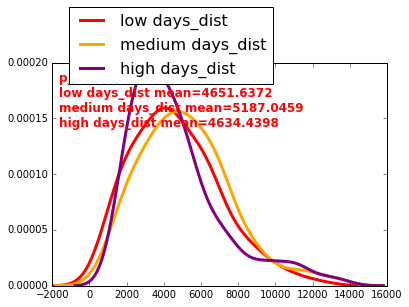

In [271]:
quant_list=[0.1,0.45,0.55,0.9]


low_days_dist=merged_Cardio126_2[merged_Cardio126_2['days_dist']<merged_Cardio126_2['days_dist'].quantile(quant_list[0])]
medium_days_dist=merged_Cardio126_2[(merged_Cardio126_2['days_dist']>merged_Cardio126_2['days_dist'].quantile(quant_list[1]))&
                              (merged_Cardio126_2['days_dist']<merged_Cardio126_2['days_dist'].quantile(quant_list[2]))]
high_days_dist=merged_Cardio126_2[merged_Cardio126_2['days_dist']>merged_Cardio126_2['days_dist'].quantile(quant_list[3])]


dataList=[('low days_dist',low_days_dist['sharing'].tolist()),
          ('medium days_dist',medium_days_dist['sharing'].tolist()),
          ('high days_dist',high_days_dist['sharing'].tolist()),
         
         ]

fig,ax=plt.subplots()
title=''

plotHistComprison(dataList,ax,title,showLegend=True,nBins=20,toAnnotate=True,
                      colorList=['red','orange','purple'],alpha=None,
                      text_kws={'fontsize':'large','fontweight':'bold','color':'red',
                                'horizontalalignment':'left','verticalalignment':'top'},
                      plotType='kde')

plt.show()

### compare distribution of day dists between different sharing levels

3
2
upTo1year    2170
1to2years    8   
Name: Binned_days_dist, dtype: int64
F value all: 0.450, p value: 0.502


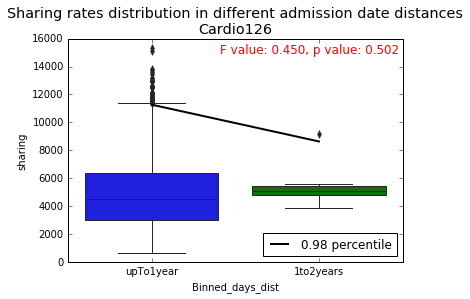

In [458]:
dataDF=merged_Cardio126_2
day_dist_col='days_dist'
sharing_col='sharing'
bin_edges=[0,365,730]
print len(bin_edges)
bin_names=['upTo1year','1to2years']
print len(bin_names)
title='Sharing rates distribution in different admission date distances\nCardio126'
usePercentile=0.98

fig,ax=plt.subplots()
ax=boxplot_sharing_by_daydist(dataDF,day_dist_col,sharing_col,bin_edges,bin_names,ax,title,usePercentile)
fig.savefig('%s/TCR_real_data/seasonality/analysis/sharing_dist_per_admission_distance_Cardio126_boxplot.png' %MyPath,bbox_inches = "tight")
plt.show()




upTo0.5year    1669
0.5to1year     501 
1to1.5years    8   
Name: Binned_days_dist, dtype: int64
F value all: 0.229, p value: 0.796


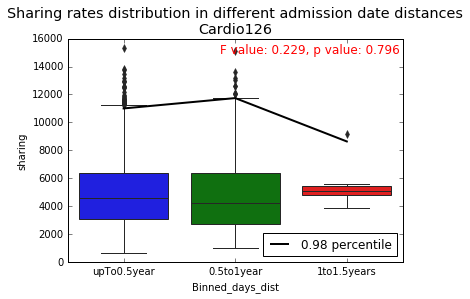

In [459]:
dataDF=merged_Cardio126_2
day_dist_col='days_dist'
sharing_col='sharing'
bin_edges=[x*182.5 for x in range(0,4)]
# print len(bin_edges)
bin_names=['upTo0.5year','0.5to1year','1to1.5years']
# print len(bin_names)
title='Sharing rates distribution in different admission date distances\nCardio126'
usePercentile=0.98

fig,ax=plt.subplots()
ax=boxplot_sharing_by_daydist(dataDF,day_dist_col,sharing_col,bin_edges,bin_names,
                              ax,title,usePercentile)
fig.savefig('%s/TCR_real_data/seasonality/analysis/sharing_dist_per_admission_distance_Cardio126_boxplot_halfyears.png' %MyPath,bbox_inches = "tight")
plt.show()




In [448]:
365./4

91.25

<3M       1016
3-6M      653 
6-9M      384 
9-12M     116 
1year+    7   
Name: Binned_days_dist, dtype: int64
F value all: 3.320, p value: 0.010


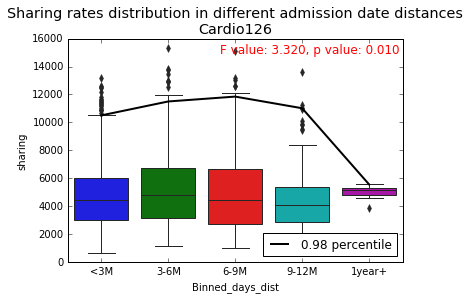

In [460]:
dataDF=merged_Cardio126_2
day_dist_col='days_dist'
sharing_col='sharing'
bin_edges=[x*91 for x in range(0,6)]
# print len(bin_edges)
bin_names=['<3M','3-6M','6-9M','9-12M','1year+']
# print len(bin_names)
title='Sharing rates distribution in different admission date distances\nCardio126'
usePercentile=0.98

fig,ax=plt.subplots()
ax=boxplot_sharing_by_daydist(dataDF,day_dist_col,sharing_col,bin_edges,bin_names,
                              ax,title,usePercentile)
fig.savefig('%s/TCR_real_data/seasonality/analysis/sharing_dist_per_admission_distance_Cardio126_boxplot_3M.png' %MyPath,bbox_inches = "tight")
plt.show()




# review seasonality prediction results:

## PNP530-by features:

In [191]:
AUC_threshold=0.6
kappa_threshold=0.2
r_threshold=0
p_r_threshold=0.05

pd.set_option('display.max_colwidth', -1)

dir1='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/seasonality/'
prediction_dirs=['seasonality_XGB50_byTCRfeatures_optByAUC/',
                 'seasonality_XGB_byTCRfeatures_optByAUC']

summaryDF=pd.DataFrame()
problematic_dirs=[]
for pred_dir in prediction_dirs:
#     f2=dir1+pred_dir+'/predictions_df.pkl'
#     predDF=pd.read_pickle(f2)
#     print ('predDF shape=',predDF.shape)
#     print predDF.tail(10)
    
    f1=dir1+pred_dir+'/results_df.pkl'
#     print d
    try:
        df= pd.read_pickle(f1)
        df['dir']=pred_dir.replace('Acute_medication_phenotypes_','')
        summaryDF=pd.concat([summaryDF,df])
    except:
        print ' couldnt get results from %s' %pred_dir
        problematic_dirs.append(pred_dir)
    print pred_dir
    print ('results_df.shape: ',df.shape)
#     print df.head()
        
print ('number of problematic dirs=',len(problematic_dirs))

interesting_cols=['dir','AUC','prevalence','Precision_Recall','kappa']
summaryDF=summaryDF.reset_index().sort_values(by=['AUC'],ascending=False).set_index('index')[interesting_cols]

summaryDF.head(10)

seasonality_XGB50_byTCRfeatures_optByAUC/
('results_df.shape: ', (34, 14))
seasonality_XGB_byTCRfeatures_optByAUC
('results_df.shape: ', (34, 14))
('number of problematic dirs=', 0)


,dir,AUC,prevalence,Precision_Recall,kappa
index,,,,,
Month_year_3_2015,seasonality_XGB_byTCRfeatures_optByAUC,0.822211,0.063781,0.210682,0.000000
Month_year_3_2015,seasonality_XGB50_byTCRfeatures_optByAUC/,0.800400,0.063781,0.189469,0.110822
Season_year_spring_2015,seasonality_XGB50_byTCRfeatures_optByAUC/,0.768074,0.063781,0.152737,0.047309
Season_year_spring_2015,seasonality_XGB_byTCRfeatures_optByAUC,0.750782,0.063781,0.178473,0.000000
Month_year_2_2014,seasonality_XGB50_byTCRfeatures_optByAUC/,0.722554,0.045558,0.089936,-0.004358
Year_2015,seasonality_XGB_byTCRfeatures_optByAUC,0.719015,0.389522,0.654118,0.306010
Year_2015,seasonality_XGB50_byTCRfeatures_optByAUC/,0.701820,0.389522,0.629934,0.335552
Month_year_4_2015,seasonality_XGB_byTCRfeatures_optByAUC,0.701256,0.056948,0.092880,0.000000
Year_2014,seasonality_XGB_byTCRfeatures_optByAUC,0.643585,0.432802,0.549335,0.159315


In [463]:
AUC_threshold=0.6
kappa_threshold=0.2
r_threshold=0
p_r_threshold=0.05

pd.set_option('display.max_colwidth', -1)

dir1='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/seasonality2/'
prediction_dirs=['seasonality_XGB50_byTCRfeatures_optByAUC/',
                 'seasonality_XGB_byTCRfeatures_optByAUC']

summaryDF=pd.DataFrame()
problematic_dirs=[]
for pred_dir in prediction_dirs:
#     f2=dir1+pred_dir+'/predictions_df.pkl'
#     predDF=pd.read_pickle(f2)
#     print ('predDF shape=',predDF.shape)
#     print predDF.tail(10)
    
    f1=dir1+pred_dir+'/results_df.pkl'
#     print d
    try:
        df= pd.read_pickle(f1)
        df['dir']=pred_dir.replace('Acute_medication_phenotypes_','')
        summaryDF=pd.concat([summaryDF,df])
    except:
        print ' couldnt get results from %s' %pred_dir
        problematic_dirs.append(pred_dir)
    print pred_dir
    print ('results_df.shape: ',df.shape)
#     print df.head()
        
print ('number of problematic dirs=',len(problematic_dirs))

interesting_cols=['dir','AUC','prevalence','Precision_Recall','kappa']
summaryDF=summaryDF.reset_index().sort_values(by=['AUC'],ascending=False).set_index('index')[interesting_cols]

summaryDF.head(15)

seasonality_XGB50_byTCRfeatures_optByAUC/
('results_df.shape: ', (34, 14))
seasonality_XGB_byTCRfeatures_optByAUC
('results_df.shape: ', (34, 14))
('number of problematic dirs=', 0)


,dir,AUC,prevalence,Precision_Recall,kappa
index,,,,,
Month_year_3_2015,seasonality_XGB50_byTCRfeatures_optByAUC/,0.794925,0.063781,0.160759,0.032458
Season_year_spring_2015,seasonality_XGB_byTCRfeatures_optByAUC,0.773375,0.063781,0.176584,0.000000
Month_year_2_2014,seasonality_XGB50_byTCRfeatures_optByAUC/,0.746659,0.045558,0.096873,-0.004358
Season_year_spring_2015,seasonality_XGB50_byTCRfeatures_optByAUC/,0.743309,0.063781,0.135364,-0.019709
Year_2015,seasonality_XGB_byTCRfeatures_optByAUC,0.722724,0.389522,0.647167,0.336759
Month_year_3_2015,seasonality_XGB_byTCRfeatures_optByAUC,0.716502,0.063781,0.147406,0.000000
Year_2015,seasonality_XGB50_byTCRfeatures_optByAUC/,0.696910,0.389522,0.625664,0.307107
Month_year_4_2015,seasonality_XGB_byTCRfeatures_optByAUC,0.652754,0.056948,0.085154,0.000000
Season_spring,seasonality_XGB_byTCRfeatures_optByAUC,0.642721,0.150342,0.232150,-0.013246


In [206]:
dir_list=[('Month_year_3_2015',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB_byTCRfeatures_optByAUC/'),
#          ('Season_year_spring_2015',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB50_byTCRfeatures_optByAUC/'),
          ('Month_year_2_2014',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB50_byTCRfeatures_optByAUC/'),
           ('Year_2015',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB_byTCRfeatures_optByAUC/'),
          ('Year_2014',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB_byTCRfeatures_optByAUC/'),
          ('Month_year_4_2015',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB_byTCRfeatures_optByAUC/'),
                  ]
pd.set_option('display.max_colwidth', -1)

shap_values_list=[]
shap_values_rank_list=[]
shap_values_top20=[]
for item in dir_list:
    print ''
    print item[0]
    df=pd.read_pickle(item[1]+'shap_values.pkl')[item[0]]
#     print df.head()
    shap_values=df.abs().sum().sort_values(ascending=False).rename(item[0])
    print shap_values.head(20)
    shap_values_list.append(shap_values)
    shap_values.to_excel(item[1]+'shap_values_abs_sum_%s.xlsx' %item[0])
    shap_values_rank=pd.DataFrame(index=shap_values.index,data={'%s_rank' %item[0]:range(shap_values.shape[0])})
    shap_values_rank_list.append(shap_values_rank)
    shap_values_top20.append(shap_values[:20])
    
all_shap=pd.concat(shap_values_list,axis=1)
all_shap_ranks=pd.concat(shap_values_rank_list,axis=1)
all_shap_values_top20=pd.concat(shap_values_top20,axis=1)
print all_shap_ranks.head()

all_shap_normed_isCardio=pd.read_excel(PRED_RESULTS_DIR+'isCardioAgeGenderHbA1C_shapSummary_11042019.xlsx')

all_shap_values_top20_merged_isCardioFeatures=pd.merge(all_shap_normed_isCardio,all_shap_ranks,
                                                       how='left',left_index=True,right_index=True)

all_shap_values_top20_merged_isCardioFeatures[:20]



    




Month_year_3_2015
D01_J01-05_0                              2.715795
J01-05_0                                  2.321889
V02_J01_1                                 1.752196
Melanoma_rel_cum_freq(perc)               1.649480
V06-04_1                                  1.569502
J01-04_0                                  1.504137
D01_J02-07_1                              1.150686
RheumatoidArthritis_rel_seq_count         1.112843
V27_J02_0                                 1.100068
V05_J01_0                                 1.082652
d3Deletion_std_1                          0.979748
V10-01_1                                  0.770355
n2Insertion_max_1                         0.768928
D02_J01-05_0                              0.683508
RheumatoidArthritis_rel_cum_freq(perc)    0.558920
D02_J01-06_0                              0.490326
D01_J01-01_0                              0.357981
frequencyCount (%)_max_1                  0.323472
V07_1                                     0.259377
V28-01_0    

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,isCardio,Age,Gender_Male,HbA1C,Month_year_3_2015_rank,Month_year_2_2014_rank,Year_2015_rank,Year_2014_rank,Month_year_4_2015_rank
NT count_0,0.063132,NaN,0.001658,NaN,NaN,NaN,NaN,NaN,NaN
V05_J02_1,0.042518,NaN,0.001582,0.029831,NaN,3.0,NaN,NaN,NaN
totalAnnotatefreqs,0.025573,NaN,0.001009,NaN,NaN,NaN,NaN,NaN,NaN
n2Insertion_mean_1,0.024753,0.001869,0.001487,NaN,NaN,NaN,32.0,NaN,NaN
PC1,0.023804,NaN,0.000571,NaN,NaN,NaN,NaN,16.0,42.0
V18-01_1,0.019116,NaN,0.000712,NaN,NaN,NaN,31.0,NaN,91.0
V05-06_1,0.015938,0.001435,0.001746,NaN,NaN,NaN,NaN,79.0,76.0
normSeqNums_per2000_NT_1,0.015907,0.038206,0.001155,0.029503,23.0,NaN,NaN,NaN,NaN
D01_J02-02_1,0.015363,NaN,0.024194,0.002971,NaN,NaN,56.0,NaN,70.0
d3Deletion_mean_0,0.015163,NaN,0.000652,NaN,NaN,NaN,1.0,NaN,NaN


## PNP530-by clusters:

In [207]:
AUC_threshold=0.6
kappa_threshold=0.2
r_threshold=0
p_r_threshold=0.05

pd.set_option('display.max_colwidth', -1)

dir1='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/seasonality/'
prediction_dirs=['seasonality_XGB500_byTCRclusters_optByAUC/',
                ]

summaryDF=pd.DataFrame()
problematic_dirs=[]
for pred_dir in prediction_dirs:
#     f2=dir1+pred_dir+'/predictions_df.pkl'
#     predDF=pd.read_pickle(f2)
#     print ('predDF shape=',predDF.shape)
#     print predDF.tail(10)
    
    f1=dir1+pred_dir+'/results_df.pkl'
#     print d
    try:
        df= pd.read_pickle(f1)
        df['dir']=pred_dir.replace('Acute_medication_phenotypes_','')
        summaryDF=pd.concat([summaryDF,df])
    except:
        print ' couldnt get results from %s' %pred_dir
        problematic_dirs.append(pred_dir)
    print pred_dir
    print ('results_df.shape: ',df.shape)
#     print df.head()
        
print ('number of problematic dirs=',len(problematic_dirs))

interesting_cols=['dir','AUC','prevalence','Precision_Recall','kappa']
summaryDF=summaryDF.reset_index().sort_values(by=['AUC'],ascending=False).set_index('index')[interesting_cols]

summaryDF.head()

seasonality_XGB500_byTCRclusters_optByAUC/
('results_df.shape: ', (34, 14))
('number of problematic dirs=', 0)


,dir,AUC,prevalence,Precision_Recall,kappa
index,,,,,
Year_2013,seasonality_XGB500_byTCRclusters_optByAUC/,0.640206,0.113895,0.197829,0.058182
Month_year_6_2014,seasonality_XGB500_byTCRclusters_optByAUC/,0.611561,0.061503,0.208530,0.130555
Season_year_spring_2015,seasonality_XGB500_byTCRclusters_optByAUC/,0.605057,0.063781,0.089872,0.000000
Month_year_3_2015,seasonality_XGB500_byTCRclusters_optByAUC/,0.597410,0.063781,0.087316,0.000000
Month_7,seasonality_XGB500_byTCRclusters_optByAUC/,0.586222,0.152620,0.195107,0.012815


In [462]:
AUC_threshold=0.6
kappa_threshold=0.2
r_threshold=0
p_r_threshold=0.05

pd.set_option('display.max_colwidth', -1)

dir1='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/seasonality2/'
prediction_dirs=['seasonality_XGB500_byTCRclusters_optByAUC/',
                ]

summaryDF=pd.DataFrame()
problematic_dirs=[]
for pred_dir in prediction_dirs:
#     f2=dir1+pred_dir+'/predictions_df.pkl'
#     predDF=pd.read_pickle(f2)
#     print ('predDF shape=',predDF.shape)
#     print predDF.tail(10)
    
    f1=dir1+pred_dir+'/results_df.pkl'
#     print d
    try:
        df= pd.read_pickle(f1)
        df['dir']=pred_dir.replace('Acute_medication_phenotypes_','')
        summaryDF=pd.concat([summaryDF,df])
    except:
        print ' couldnt get results from %s' %pred_dir
        problematic_dirs.append(pred_dir)
    print pred_dir
    print ('results_df.shape: ',df.shape)
#     print df.head()
        
print ('number of problematic dirs=',len(problematic_dirs))

interesting_cols=['dir','AUC','prevalence','Precision_Recall','kappa']
summaryDF=summaryDF.reset_index().sort_values(by=['AUC'],ascending=False).set_index('index')[interesting_cols]

summaryDF.head()

seasonality_XGB500_byTCRclusters_optByAUC/
('results_df.shape: ', (34, 14))
('number of problematic dirs=', 0)


,dir,AUC,prevalence,Precision_Recall,kappa
index,,,,,
Year_2013,seasonality_XGB500_byTCRclusters_optByAUC/,0.643702,0.113895,0.224161,0.025167
Month_year_3_2015,seasonality_XGB500_byTCRclusters_optByAUC/,0.632343,0.063781,0.085662,0.000000
Season_year_spring_2015,seasonality_XGB500_byTCRclusters_optByAUC/,0.624957,0.063781,0.093729,0.000000
Season_year_summer_2014,seasonality_XGB500_byTCRclusters_optByAUC/,0.609493,0.175399,0.319388,0.057751
Month_year_6_2014,seasonality_XGB500_byTCRclusters_optByAUC/,0.598706,0.061503,0.235241,0.130555


In [209]:
dir_list=[('Year_2013',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB500_byTCRclusters_optByAUC/'),
         ('Month_year_6_2014',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB500_byTCRclusters_optByAUC/'),
          ('Month_year_3_2015',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB500_byTCRclusters_optByAUC/'),

                  ]

shap_values_list=[]
shap_values_rank_list=[]
shap_values_top20=[]
for item in dir_list:
    print ''
    print item[0]
    df=pd.read_pickle(item[1]+'shap_values.pkl')[item[0]]
#     print df.head()
    shap_values=df.abs().sum().sort_values(ascending=False).rename(item[0])
    print shap_values.head(20)
    shap_values_list.append(shap_values)
    shap_values.to_excel(item[1]+'shap_values_abs_sum_%s.xlsx' %item[0])
    shap_values_rank=pd.DataFrame(index=shap_values.index,data={'%s_rank' %item[0]:range(shap_values.shape[0])})
    shap_values_rank_list.append(shap_values_rank)
    shap_values_top20.append(shap_values[:20])
    
all_shap=pd.concat(shap_values_list,axis=1)
all_shap_ranks=pd.concat(shap_values_rank_list,axis=1)
all_shap_values_top20=pd.concat(shap_values_top20,axis=1)
all_shap_ranks.head()


top100df=pd.read_excel('/net/mraid08/export/jafar/Microbiome/Analyses/TCR/TCR_seqs_clusters/top100_clusterDF_PNP530_binary.xlsx').set_index('BD')
TOP100list=top100df.columns.tolist()  

all_shap_ranks_top100=all_shap_ranks.loc[TOP100list,:].dropna(how='all')
all_shap_ranks_top100




Year_2013
CASSGGSYEQYF       48.858212
CASSQVSDTQYF       28.180770
CASSEGGEQYF        10.162524
CASSQNRGNYGYTF     8.740054 
CASSTLAGQETQYF     8.231467 
CASSRQGGTEAFF      7.969032 
CASSLGDGGNTEAFF    7.191982 
CASSRGGEQYF        6.979183 
CASSEAASTDTQYF     6.739426 
CASSPGTGYYEQYF     6.043270 
CASSPAGAQETQYF     6.010476 
CASSLGWEQYF        5.807661 
CASSQGDEQYF        5.395440 
CASSKRDRSYEQYF     5.361628 
CASSFGGNTEAFF      4.793861 
CASSLERANTGELFF    4.676504 
CASSPDSYNEQFF      4.185080 
CASSVRTENTEAFF     4.042502 
CASSSDSYNEQFF      3.833979 
CASSLDGGTQYF       3.540307 
Name: Year_2013, dtype: float64

Month_year_6_2014
CASSLATGELFF       14.748714
CASSQGGYEQYF       7.067909 
CASSHSPYEQYF       6.649172 
CASSTVNYGYTF       6.507345 
CASSRQFYEQYF       6.374072 
CASSLGPSGYTF       4.257573 
CASSIGGYGYTF       3.615193 
CASSFDMNTEAFF      3.376733 
CASSFNSYEQYF       3.245476 
CASSLQDNYGYTF      2.898133 
CASSSGGSYGYTF      2.801424 
CASSLRGGLYNEQFF    2.651483 
CASSPGTRYE

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Year_2013_rank,Month_year_6_2014_rank,Month_year_3_2015_rank
CASSDRETGELFF,NaN,NaN,24.0


## PNP530 BY PHENOTYPES:

In [464]:
AUC_threshold=0.6
kappa_threshold=0.2
r_threshold=0
p_r_threshold=0.05

pd.set_option('display.max_colwidth', -1)

dir1='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/seasonality2/'
prediction_dirs=['seasonality_XGB_byMajorPhenotypes_optByAUC/',
                ]

summaryDF=pd.DataFrame()
problematic_dirs=[]
for pred_dir in prediction_dirs:
#     f2=dir1+pred_dir+'/predictions_df.pkl'
#     predDF=pd.read_pickle(f2)
#     print ('predDF shape=',predDF.shape)
#     print predDF.tail(10)
    
    f1=dir1+pred_dir+'/results_df.pkl'
#     print d
    try:
        df= pd.read_pickle(f1)
        df['dir']=pred_dir.replace('Acute_medication_phenotypes_','')
        summaryDF=pd.concat([summaryDF,df])
    except:
        print ' couldnt get results from %s' %pred_dir
        problematic_dirs.append(pred_dir)
    print pred_dir
    print ('results_df.shape: ',df.shape)
#     print df.head()
        
print ('number of problematic dirs=',len(problematic_dirs))

interesting_cols=['dir','AUC','prevalence','Precision_Recall','kappa']
summaryDF=summaryDF.reset_index().sort_values(by=['AUC'],ascending=False).set_index('index')[interesting_cols]

summaryDF.head(10)

seasonality_XGB_byMajorPhenotypes_optByAUC/
('results_df.shape: ', (34, 14))
('number of problematic dirs=', 0)


,dir,AUC,prevalence,Precision_Recall,kappa
index,,,,,
Season_year_spring_2015,seasonality_XGB_byMajorPhenotypes_optByAUC/,0.744830,0.063781,0.263669,0.064852
Month_year_3_2015,seasonality_XGB_byMajorPhenotypes_optByAUC/,0.740007,0.063781,0.246963,-0.012499
Month_3,seasonality_XGB_byMajorPhenotypes_optByAUC/,0.639227,0.150342,0.236091,-0.008923
Season_spring,seasonality_XGB_byMajorPhenotypes_optByAUC/,0.616155,0.150342,0.242672,0.000000
Month_year_7_2014,seasonality_XGB_byMajorPhenotypes_optByAUC/,0.613333,0.056948,0.081329,0.000000
Year_2013,seasonality_XGB_byMajorPhenotypes_optByAUC/,0.603779,0.113895,0.156585,-0.008839
Month_5,seasonality_XGB_byMajorPhenotypes_optByAUC/,0.601951,0.141230,0.186143,-0.033358
Season_year_summer_2015,seasonality_XGB_byMajorPhenotypes_optByAUC/,0.592001,0.154897,0.227528,0.000000
Month_7,seasonality_XGB_byMajorPhenotypes_optByAUC/,0.583955,0.152620,0.202048,-0.013255


In [218]:
AUC_threshold=0.6
kappa_threshold=0.2
r_threshold=0
p_r_threshold=0.05

pd.set_option('display.max_colwidth', -1)

dir1='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/seasonality/'
prediction_dirs=['seasonality_XGB_byMajorPhenotypes_optByAUC/',
                ]

summaryDF=pd.DataFrame()
problematic_dirs=[]
for pred_dir in prediction_dirs:
#     f2=dir1+pred_dir+'/predictions_df.pkl'
#     predDF=pd.read_pickle(f2)
#     print ('predDF shape=',predDF.shape)
#     print predDF.tail(10)
    
    f1=dir1+pred_dir+'/results_df.pkl'
#     print d
    try:
        df= pd.read_pickle(f1)
        df['dir']=pred_dir.replace('Acute_medication_phenotypes_','')
        summaryDF=pd.concat([summaryDF,df])
    except:
        print ' couldnt get results from %s' %pred_dir
        problematic_dirs.append(pred_dir)
    print pred_dir
    print ('results_df.shape: ',df.shape)
#     print df.head()
        
print ('number of problematic dirs=',len(problematic_dirs))

interesting_cols=['dir','AUC','prevalence','Precision_Recall','kappa']
summaryDF=summaryDF.reset_index().sort_values(by=['AUC'],ascending=False).set_index('index')[interesting_cols]

summaryDF.head(10)

seasonality_XGB_byMajorPhenotypes_optByAUC/
('results_df.shape: ', (34, 14))
('number of problematic dirs=', 0)


,dir,AUC,prevalence,Precision_Recall,kappa
index,,,,,
Season_year_spring_2015,seasonality_XGB_byMajorPhenotypes_optByAUC/,0.755648,0.063781,0.230255,-0.004418
Month_year_3_2015,seasonality_XGB_byMajorPhenotypes_optByAUC/,0.740528,0.063781,0.299373,0.165693
Season_spring,seasonality_XGB_byMajorPhenotypes_optByAUC/,0.654034,0.150342,0.251923,0.000000
Month_year_2_2014,seasonality_XGB_byMajorPhenotypes_optByAUC/,0.640274,0.045558,0.085504,0.000000
Month_3,seasonality_XGB_byMajorPhenotypes_optByAUC/,0.617434,0.150342,0.228945,0.000000
Month_year_12_2013,seasonality_XGB_byMajorPhenotypes_optByAUC/,0.607284,0.079727,0.107057,0.030680
Month_year_7_2014,seasonality_XGB_byMajorPhenotypes_optByAUC/,0.601691,0.056948,0.070622,0.000000
Season_year_summer_2015,seasonality_XGB_byMajorPhenotypes_optByAUC/,0.599552,0.154897,0.215073,-0.013264
Month_year_7_2015,seasonality_XGB_byMajorPhenotypes_optByAUC/,0.596408,0.095672,0.172163,0.000000


In [219]:
dir_list=[('Season_year_spring_2015',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB_byMajorPhenotypes_optByAUC/'),
         ('Season_spring',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB_byMajorPhenotypes_optByAUC/'),
          ('Month_year_2_2014',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB_byMajorPhenotypes_optByAUC/'),
              ('Month_year_12_2013',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB_byMajorPhenotypes_optByAUC/'),
              ('Month_year_7_2014',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB_byMajorPhenotypes_optByAUC/'),
           ('Month_year_7_2015',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB_byMajorPhenotypes_optByAUC/'),

                  ]

shap_values_list=[]
shap_values_rank_list=[]
shap_values_top20=[]
for item in dir_list:
    print ''
    print item[0]
    df=pd.read_pickle(item[1]+'shap_values.pkl')[item[0]]
#     print df.head()
    shap_values=df.abs().sum().sort_values(ascending=False).rename(item[0])
    print shap_values.head(20)
    shap_values_list.append(shap_values)
    shap_values.to_excel(item[1]+'shap_values_abs_sum_%s.xlsx' %item[0])
    shap_values_rank=pd.DataFrame(index=shap_values.index,data={'%s_rank' %item[0]:range(shap_values.shape[0])})
    shap_values_rank_list.append(shap_values_rank)
    shap_values_top20.append(shap_values[:20])
    
all_shap=pd.concat(shap_values_list,axis=1)
all_shap_ranks=pd.concat(shap_values_rank_list,axis=1)
all_shap_values_top20=pd.concat(shap_values_top20,axis=1)
all_shap_ranks.head()


# top100df=pd.read_excel('/net/mraid08/export/jafar/Microbiome/Analyses/TCR/TCR_seqs_clusters/top100_clusterDF_PNP530_binary.xlsx').set_index('BD')
# TOP100list=top100df.columns.tolist()  

# all_shap_ranks_top100=all_shap_ranks.loc[TOP100list,:].dropna(how='all')
# all_shap_ranks_top100




Season_year_spring_2015
Series([], Name: Season_year_spring_2015, dtype: float64)

Season_spring
HbA1C                 44.969116
Age                   6.106934 
Smoking Status_Yes    0.756388 
Smoking_ever          0.127179 
Name: Season_spring, dtype: float64

Month_year_2_2014
Age    2.392251
Name: Month_year_2_2014, dtype: float64

Month_year_12_2013
Smoking Status_Yes    2.950939
Name: Month_year_12_2013, dtype: float64

Month_year_7_2014
Series([], Name: Month_year_7_2014, dtype: float64)

Month_year_7_2015
HbA1C                 53.471569
Smoking Status_Yes    1.080269 
Name: Month_year_7_2015, dtype: float64


/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Season_year_spring_2015_rank,Season_spring_rank,Month_year_2_2014_rank,Month_year_12_2013_rank,Month_year_7_2014_rank,Month_year_7_2015_rank
Age,NaN,1,0.0,NaN,NaN,NaN
HbA1C,NaN,0,NaN,NaN,NaN,0.0
Smoking Status_Yes,NaN,2,NaN,0.0,NaN,1.0
Smoking_ever,NaN,3,NaN,NaN,NaN,NaN


### compare phenotypes of subjects seperated by predicted "season":

In [275]:
dates_PNP530=pd.read_excel(SEASON_DIR+'AdmissionDates_PNP530.xlsx').rename(columns={'DnaID':'BD'}).set_index('BD')
dates_PNP530.to_excel(SEASON_DIR+'AdmissionDates_PNP530.xlsx')
print dates_PNP530.shape
dates_PNP530.head()

(439, 6)


,Blood_Date,Month,Year,Season,Month_year,Season_year
BD,,,,,,
BD406,2015-03-18,3,2015,spring,3_2015,spring_2015
BD228,2014-03-26,3,2014,spring,3_2014,spring_2014
BD714,2014-09-14,9,2014,automn,9_2014,automn_2014
BD808,2013-12-22,12,2013,winter,12_2013,winter_2013
BD144,2014-05-27,5,2014,automn,5_2014,automn_2014


In [293]:

def compare_phenotypes_diff_seasons(dates_column,dates_value,datasetName):

    f1='/net/mraid08/export/jafar/Microbiome/Analyses/TCR/\
phenotypes_byBD/%s_Age_Gender_Male_HbA1C_SmokingStatus_Yes_BMI_HDL_Smoking_ever_nonHDL_Cholesterol.xlsx' %datasetName
    
    phenotypeDF=pd.read_excel(f1).set_index('BD')
    if datasetName == 'PNP530':
        dates_file=SEASON_DIR+'AdmissionDates_PNP530.xlsx'
    elif datasetName == 'Cardio126':
        dates_file=SEASON_DIR+'Admissiondates_cardio_PNP530.xlsx'
    dates=pd.read_excel(dates_file).set_index('BD')

    sampleList1=dates[dates[dates_column]==dates_value].index.tolist()
    sampleList2=dates[dates[dates_column]!=dates_value].index.tolist()

    print ('number of samples in sampleList1=%s' %len(sampleList1))
    print ('number of samples in sampleList2=%s' %len(sampleList2))

    numericalphenotypes=['Age','BMI','HbA1C','HDL','nonHDL_Cholesterol']
    categoricalphenotypes=['Gender_Male', 'Smoking Status_Yes','Smoking_ever']
    phenotypeDF1=phenotypeDF
    datasetName1=datasetName
    sampleListName1=dates_column+'_is_' + dates_value
    phenotypeDF2=phenotypeDF
    datasetName2=datasetName
    sampleListName2=dates_column+'_isnot_' + dates_value
    nBins=10



    fig1=compare_phenotypes(numericalphenotypes, categoricalphenotypes, nBins, phenotypeDF1, sampleList1, sampleListName1,datasetName1,
                           phenotypeDF2, sampleList2, sampleListName2,datasetName2,widthUnit=3,heightUnit=3)
    
    return fig1


number of samples in sampleList1=28
number of samples in sampleList2=411
0 Age
1 BMI
2 HbA1C
3 HDL
4 nonHDL_Cholesterol
0 Gender_Male
1 Smoking Status_Yes
2 Smoking_ever


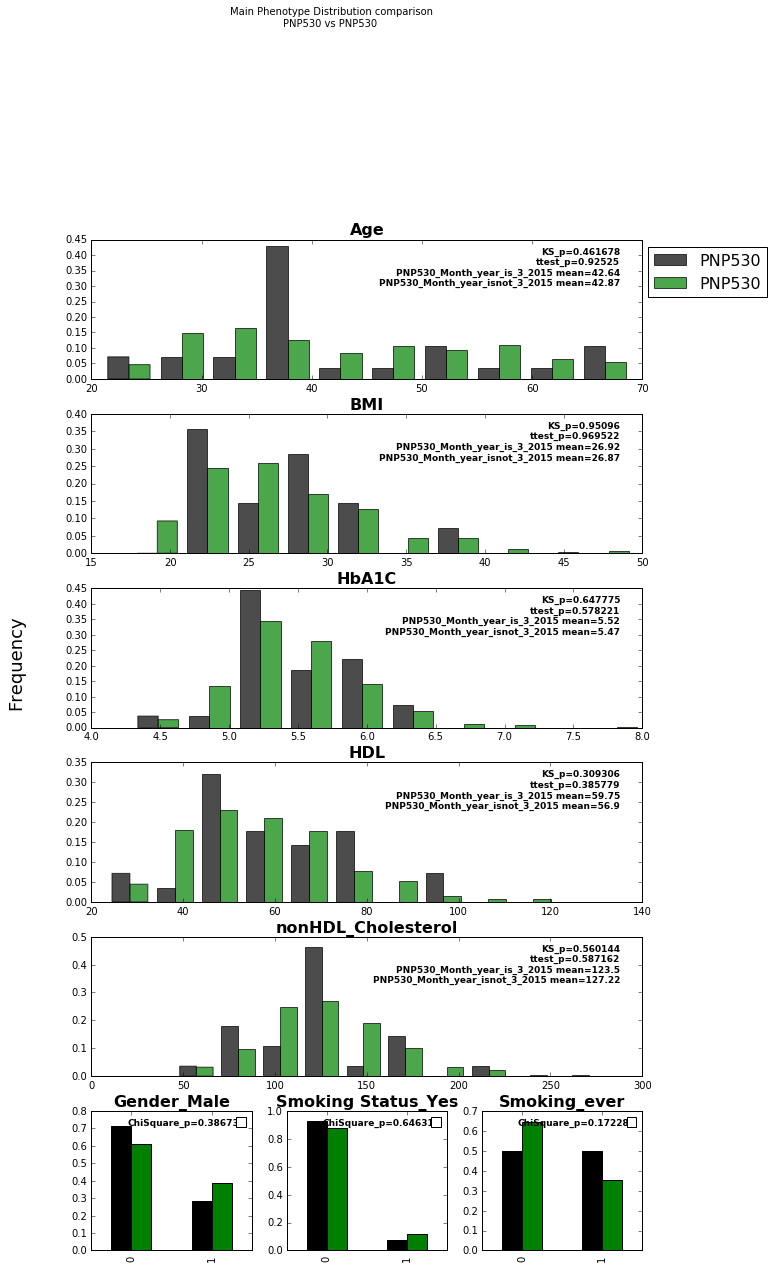

figure was saved in folder TCR_real_data/realAnalysis
done


In [294]:
dates_column='Month_year'
dates_value='3_2015'
datasetName='PNP530'

fig1=compare_phenotypes_diff_seasons(dates_column,dates_value,datasetName)

number of samples in sampleList1=28
number of samples in sampleList2=411
0 Age
1 BMI
2 HbA1C
3 HDL
4 nonHDL_Cholesterol
0 Gender_Male
1 Smoking Status_Yes
2 Smoking_ever


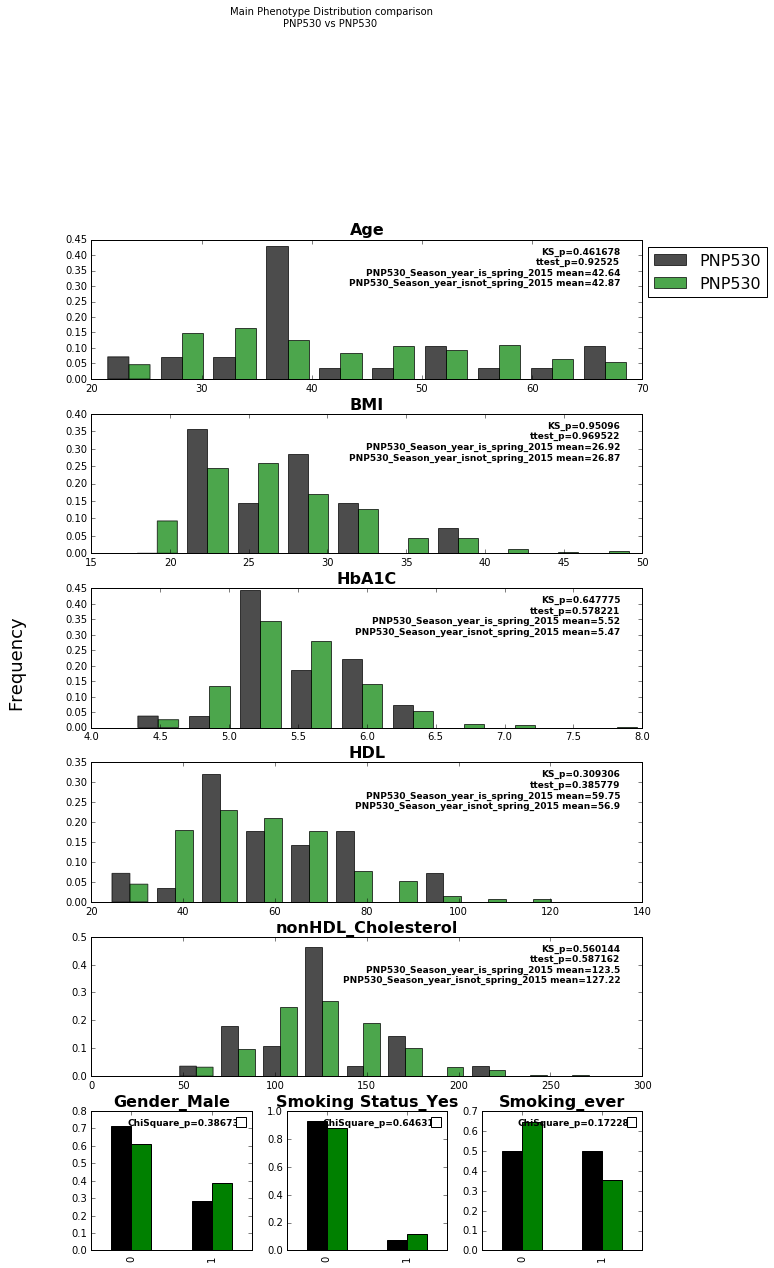

figure was saved in folder TCR_real_data/realAnalysis
done


In [298]:
dates_column='Season_year'
dates_value='spring_2015'
datasetName='PNP530'

fig1=compare_phenotypes_diff_seasons(dates_column,dates_value,datasetName)

number of samples in sampleList1=20
number of samples in sampleList2=419
0 Age
1 BMI
2 HbA1C
3 HDL
4 nonHDL_Cholesterol
0 Gender_Male
1 Smoking Status_Yes
2 Smoking_ever


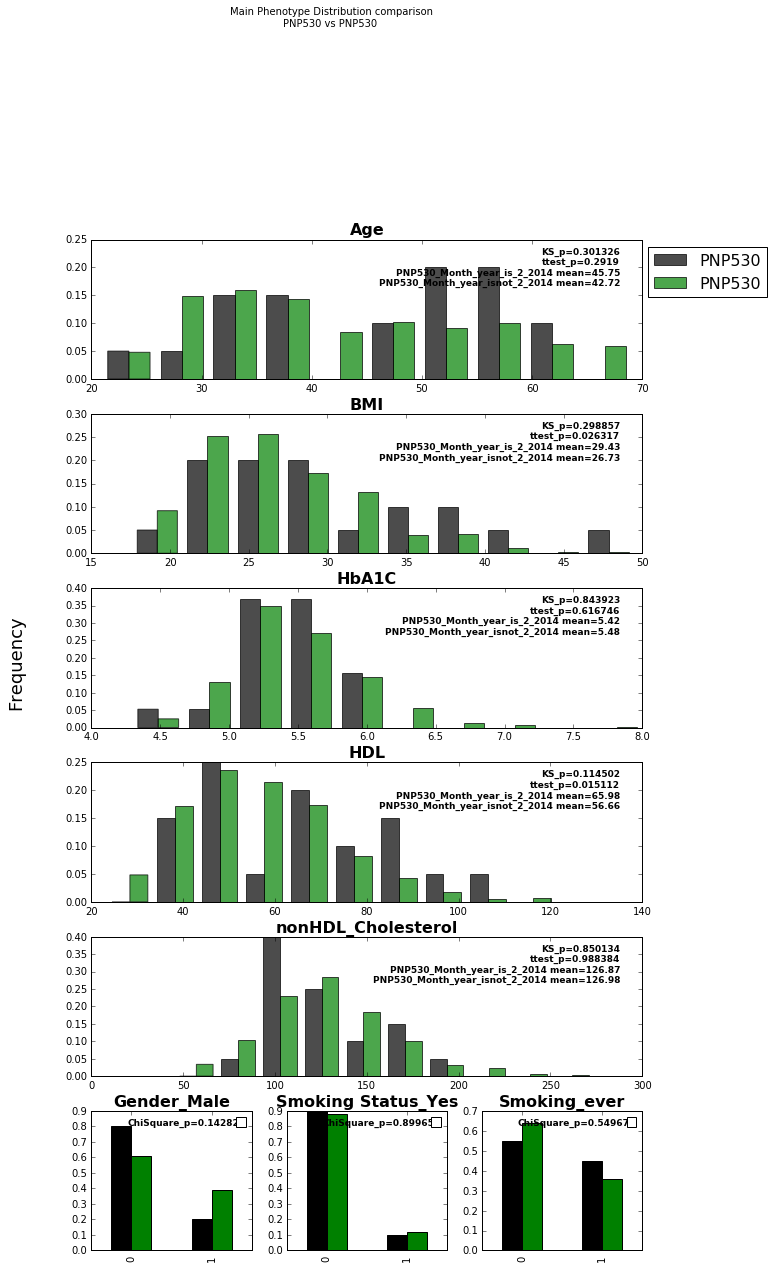

figure was saved in folder TCR_real_data/realAnalysis
done


In [299]:
dates_column='Month_year'
dates_value='2_2014'
datasetName='PNP530'

fig1=compare_phenotypes_diff_seasons(dates_column,dates_value,datasetName)

number of samples in sampleList1=42
number of samples in sampleList2=397
0 Age
1 BMI
2 HbA1C
3 HDL
4 nonHDL_Cholesterol
0 Gender_Male
1 Smoking Status_Yes
2 Smoking_ever


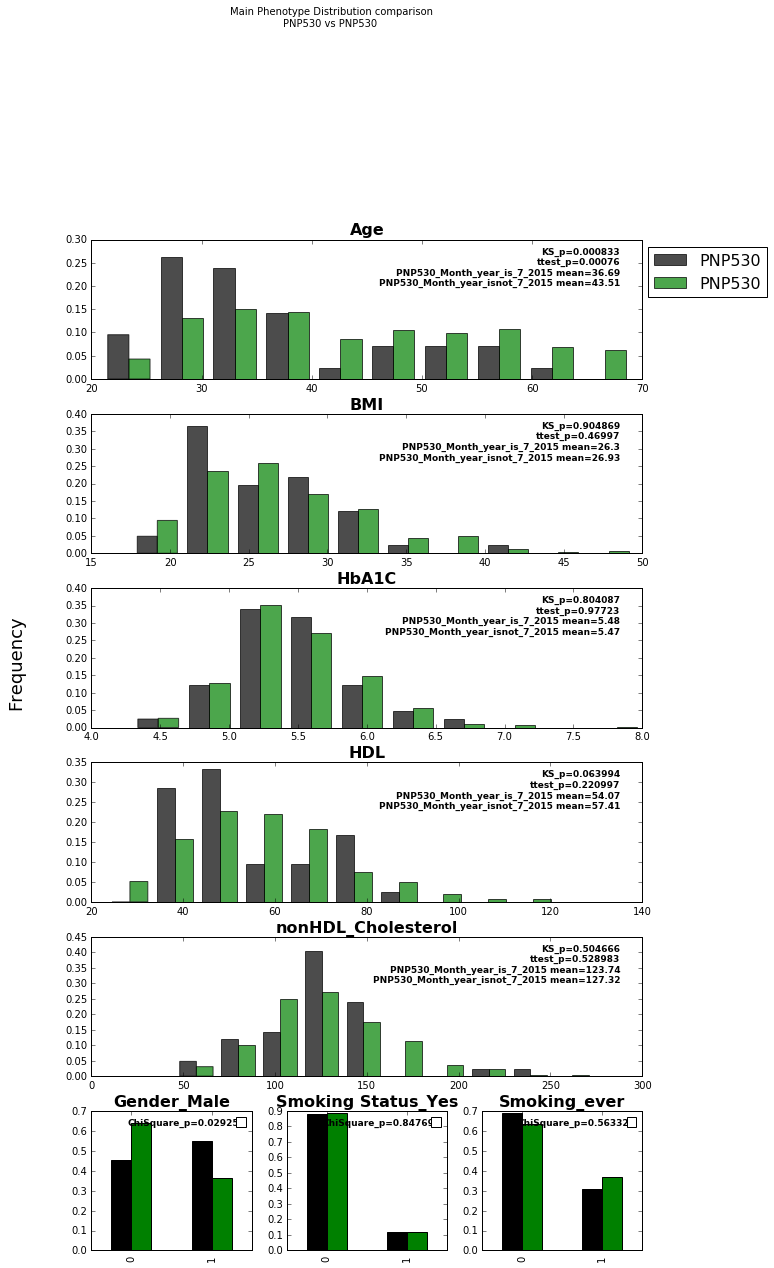

figure was saved in folder TCR_real_data/realAnalysis
done


In [300]:
dates_column='Month_year'
dates_value='7_2015'
datasetName='PNP530'

fig1=compare_phenotypes_diff_seasons(dates_column,dates_value,datasetName)

## Cardio126-by features:

In [210]:
AUC_threshold=0.6
kappa_threshold=0.2
r_threshold=0
p_r_threshold=0.05

pd.set_option('display.max_colwidth', -1)

dir1='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/seasonality/'
prediction_dirs=['seasonality_XGB50_byTCRfeatures_optByAUC_Cardio126/',
                 'seasonality_XGB_byTCRfeatures_optByAUC_Cardio126']

summaryDF=pd.DataFrame()
problematic_dirs=[]
for pred_dir in prediction_dirs:
#     f2=dir1+pred_dir+'/predictions_df.pkl'
#     predDF=pd.read_pickle(f2)
#     print ('predDF shape=',predDF.shape)
#     print predDF.tail(10)
    
    f1=dir1+pred_dir+'/results_df.pkl'
#     print d
    try:
        df= pd.read_pickle(f1)
        df['dir']=pred_dir.replace('Acute_medication_phenotypes_','')
        summaryDF=pd.concat([summaryDF,df])
    except:
        print ' couldnt get results from %s' %pred_dir
        problematic_dirs.append(pred_dir)
    print pred_dir
    print ('results_df.shape: ',df.shape)
#     print df.head()
        
print ('number of problematic dirs=',len(problematic_dirs))

interesting_cols=['dir','AUC','prevalence','Precision_Recall','kappa']
summaryDF=summaryDF.reset_index().sort_values(by=['AUC'],ascending=False).set_index('index')[interesting_cols]

summaryDF.head(10)

seasonality_XGB50_byTCRfeatures_optByAUC_Cardio126/
('results_df.shape: ', (25, 14))
seasonality_XGB_byTCRfeatures_optByAUC_Cardio126
('results_df.shape: ', (25, 14))
('number of problematic dirs=', 0)


,dir,AUC,prevalence,Precision_Recall,kappa
index,,,,,
Year_2018,seasonality_XGB_byTCRfeatures_optByAUC_Cardio126,0.733848,0.082474,0.165842,0.000000
Year_2018,seasonality_XGB50_byTCRfeatures_optByAUC_Cardio126/,0.699438,0.082474,0.169439,0.000000
Month_4,seasonality_XGB_byTCRfeatures_optByAUC_Cardio126,0.697674,0.113402,0.265998,0.000000
Month_1,seasonality_XGB_byTCRfeatures_optByAUC_Cardio126,0.696032,0.072165,0.245548,0.000000
Year_2017,seasonality_XGB50_byTCRfeatures_optByAUC_Cardio126/,0.693820,0.917526,0.956151,0.000000
Month_year_4_2017,seasonality_XGB_byTCRfeatures_optByAUC_Cardio126,0.690805,0.103093,0.421803,0.000000
Year_2017,seasonality_XGB_byTCRfeatures_optByAUC_Cardio126,0.663624,0.917526,0.960782,0.000000
Season_year_automn_2017,seasonality_XGB_byTCRfeatures_optByAUC_Cardio126,0.649425,0.402062,0.504354,0.061807
Month_5,seasonality_XGB50_byTCRfeatures_optByAUC_Cardio126/,0.636275,0.123711,0.173012,0.000000


In [212]:
dir_list=[('Year_2018',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB_byTCRfeatures_optByAUC_Cardio126/'),
#          ('Season_year_spring_2015',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB50_byTCRfeatures_optByAUC/'),
          ('Month_year_4_2017',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB_byTCRfeatures_optByAUC_Cardio126/'),
           ('Month_1',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB_byTCRfeatures_optByAUC_Cardio126/'),
          ('Year_2017',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB_byTCRfeatures_optByAUC_Cardio126/'),
          ('Season_year_automn_2017',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB_byTCRfeatures_optByAUC_Cardio126/'),
                  ]
pd.set_option('display.max_colwidth', -1)

shap_values_list=[]
shap_values_rank_list=[]
shap_values_top20=[]
for item in dir_list:
    print ''
    print item[0]
    df=pd.read_pickle(item[1]+'shap_values.pkl')[item[0]]
#     print df.head()
    shap_values=df.abs().sum().sort_values(ascending=False).rename(item[0])
    print shap_values.head(20)
    shap_values_list.append(shap_values)
    shap_values.to_excel(item[1]+'shap_values_abs_sum_%s.xlsx' %item[0])
    shap_values_rank=pd.DataFrame(index=shap_values.index,data={'%s_rank' %item[0]:range(shap_values.shape[0])})
    shap_values_rank_list.append(shap_values_rank)
    shap_values_top20.append(shap_values[:20])
    
all_shap=pd.concat(shap_values_list,axis=1)
all_shap_ranks=pd.concat(shap_values_rank_list,axis=1)
all_shap_values_top20=pd.concat(shap_values_top20,axis=1)
print all_shap_ranks.head()

all_shap_normed_isCardio=pd.read_excel(PRED_RESULTS_DIR+'isCardioAgeGenderHbA1C_shapSummary_11042019.xlsx')

all_shap_values_top20_merged_isCardioFeatures=pd.merge(all_shap_normed_isCardio,all_shap_ranks,
                                                       how='left',left_index=True,right_index=True)

all_shap_values_top20_merged_isCardioFeatures[:20]



    




Year_2018
frequencyCount (%)_max_0            1.607135
V19_J02_1                           1.495424
Influenza_rel_seq_count             1.340904
totalAnnotatefreqs                  1.014507
V12-05_1                            0.885709
D01_J02-06_1                        0.562301
PC1                                 0.543927
V19_J02_0                           0.496320
V04-01_0                            0.485604
V21_0                               0.350258
DiabetesType1_rel_cum_freq(perc)    0.334407
V11_J02_0                           0.203377
V30_J02_0                           0.187226
V05-06_1                            0.158976
J01-05_1                            0.084114
jDeletion_std_1                     0.083526
V06-01_0                            0.061643
simpson_nt_0                        0.024697
normSeqNums_per200_AA_0             0.024261
D02_J02-01_1                        0.021361
Name: Year_2018, dtype: float64

Month_year_4_2017
V10_J01_0                           3.

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



                                 Year_2018_rank  Month_year_4_2017_rank  Month_1_rank  Year_2017_rank  Season_year_automn_2017_rank
AA count_0                      NaN              57.0                   NaN           NaN              46.0                        
AA count_1                      NaN             NaN                      16.0         NaN              39.0                        
Allergy_rel_cum_freq(perc)      NaN              30.0                   NaN           NaN             NaN                          
Allergy_rel_seq_count           NaN             NaN                      20.0         NaN             NaN                          
BreastCancer_rel_cum_freq(perc) NaN             NaN                     NaN           NaN              38.0                        


,isCardio,Age,Gender_Male,HbA1C,Year_2018_rank,Month_year_4_2017_rank,Month_1_rank,Year_2017_rank,Season_year_automn_2017_rank
NT count_0,0.063132,NaN,0.001658,NaN,NaN,NaN,NaN,NaN,41.0
V05_J02_1,0.042518,NaN,0.001582,0.029831,NaN,NaN,NaN,NaN,NaN
totalAnnotatefreqs,0.025573,NaN,0.001009,NaN,3.0,NaN,51.0,23.0,NaN
n2Insertion_mean_1,0.024753,0.001869,0.001487,NaN,NaN,NaN,NaN,NaN,NaN
PC1,0.023804,NaN,0.000571,NaN,6.0,NaN,NaN,NaN,35.0
V18-01_1,0.019116,NaN,0.000712,NaN,NaN,NaN,NaN,NaN,NaN
V05-06_1,0.015938,0.001435,0.001746,NaN,13.0,NaN,NaN,12.0,NaN
normSeqNums_per2000_NT_1,0.015907,0.038206,0.001155,0.029503,NaN,NaN,NaN,NaN,NaN
D01_J02-02_1,0.015363,NaN,0.024194,0.002971,NaN,NaN,NaN,NaN,NaN
d3Deletion_mean_0,0.015163,NaN,0.000652,NaN,NaN,NaN,NaN,NaN,NaN


## Cardio126-by clusters:

In [221]:
AUC_threshold=0.6
kappa_threshold=0.2
r_threshold=0
p_r_threshold=0.05

pd.set_option('display.max_colwidth', -1)

dir1='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/seasonality/'
prediction_dirs=['seasonality_XGB500_byTCRclusters_optByAUC_Cardio126/',
                ]

summaryDF=pd.DataFrame()
problematic_dirs=[]
for pred_dir in prediction_dirs:
#     f2=dir1+pred_dir+'/predictions_df.pkl'
#     predDF=pd.read_pickle(f2)
#     print ('predDF shape=',predDF.shape)
#     print predDF.tail(10)
    
    f1=dir1+pred_dir+'/results_df.pkl'
#     print d
    try:
        df= pd.read_pickle(f1)
        df['dir']=pred_dir.replace('Acute_medication_phenotypes_','')
        summaryDF=pd.concat([summaryDF,df])
    except:
        print ' couldnt get results from %s' %pred_dir
        problematic_dirs.append(pred_dir)
    print pred_dir
    print ('results_df.shape: ',df.shape)
#     print df.head()
        
print ('number of problematic dirs=',len(problematic_dirs))

interesting_cols=['dir','AUC','prevalence','Precision_Recall','kappa']
summaryDF=summaryDF.reset_index().sort_values(by=['AUC'],ascending=False).set_index('index')[interesting_cols]

summaryDF.head()

seasonality_XGB500_byTCRclusters_optByAUC_Cardio126/
('results_df.shape: ', (25, 14))
('number of problematic dirs=', 0)


,dir,AUC,prevalence,Precision_Recall,kappa
index,,,,,
Month_1,seasonality_XGB500_byTCRclusters_optByAUC_Cardio126/,0.673016,0.072165,0.096667,0.000000
Month_year_12_2017,seasonality_XGB500_byTCRclusters_optByAUC_Cardio126/,0.664326,0.082474,0.130112,0.000000
Season_summer,seasonality_XGB500_byTCRclusters_optByAUC_Cardio126/,0.617140,0.298969,0.383512,0.080278
Season_year_summer_2017,seasonality_XGB500_byTCRclusters_optByAUC_Cardio126/,0.614907,0.288660,0.416310,0.148548
Month_12,seasonality_XGB500_byTCRclusters_optByAUC_Cardio126/,0.606742,0.082474,0.127313,0.000000


In [225]:
dir_list=[('Month_1',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB500_byTCRclusters_optByAUC_Cardio126/'),
#          ('Season_year_spring_2015',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB50_byTCRfeatures_optByAUC/'),
          ('Month_year_12_2017',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB500_byTCRclusters_optByAUC_Cardio126/'),
           ('Season_summer',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB500_byTCRclusters_optByAUC_Cardio126/'),
          ('Season_year_summer_2017',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB500_byTCRclusters_optByAUC_Cardio126/'),
#           ('Season_year_automn_2017',PRED_RESULTS_DIR + 'seasonality_XGB500_byTCRclusters_optByAUC_Cardio126/'),
                  ]
pd.set_option('display.max_colwidth', -1)

shap_values_list=[]
shap_values_rank_list=[]
shap_values_top20=[]
for item in dir_list:
    print ''0.07
    print item[0]
    df=pd.read_pickle(item[1]+'shap_values.pkl')[item[0]]
#     print df.head()
    shap_values=df.abs().sum().sort_values(ascending=False).rename(item[0])
    print shap_values.head(20)
    shap_values_list.append(shap_values)
    shap_values.to_excel(item[1]+'shap_values_abs_sum_%s.xlsx' %item[0])
    shap_values_rank=pd.DataFrame(index=shap_values.index,data={'%s_rank' %item[0]:range(shap_values.shape[0])})
    shap_values_rank_list.append(shap_values_rank)
    shap_values_top20.append(shap_values[:20])
    
all_shap=pd.concat(shap_values_list,axis=1)
all_shap_ranks=pd.concat(shap_values_rank_list,axis=1)
all_shap_values_top20=pd.concat(shap_values_top20,axis=1)
print all_shap_ranks.head()

all_shap_normed_isCardio=pd.read_excel(PRED_RESULTS_DIR+'isCardioAgeGenderHbA1C_shapSummary_11042019.xlsx')

all_shap_values_top20_merged_isCardioFeatures=pd.merge(all_shap_normed_isCardio,all_shap_ranks,
                                                       how='left',left_index=True,right_index=True)

all_shap_values_top20_merged_isCardioFeatures[:20]



    




Month_1
CASSEDFYEQYF       2.221668
CASSPTVSSYNEQFF    1.442125
CASSLGPKYEQYF      1.350443
CASSFLSQETQYF      1.271324
CASSRLENTEAFF      1.205955
CASSMDRGYEQYF      1.092289
CASRGQGRTGELFF     0.888806
CASSRGLAGDNEQFF    0.885096
CASRGAGNTEAFF      0.856914
CASSLFANTGELFF     0.806979
CASSHTSGQETQYF     0.663326
CASSDGTGVYEQYF     0.623013
CASSYRAEAFF        0.615033
CASSLGAGKETQYF     0.547216
CASSFSGVSYNEQFF    0.496176
CASSLAGANTGELFF    0.427743
CASSDDPYEQYF       0.423958
CASSYGGNYEQYF      0.398323
CASSLSSGAYNEQFF    0.396040
CASSSGLAGDNEQFF    0.388970
Name: Month_1, dtype: float64

Month_year_12_2017
CASSSHGGYEQYF      1.995131
CASSQDWETQYF       1.367778
CASSLTLGSYEQYF     1.143536
CASSSIREQYF        1.056991
CASSGDGETQYF       1.032946
CASSLSGSLYEQYF     0.897642
CASSPLAGSTDTQYF    0.872455
CASSLGGQPYGYTF     0.868492
CASSPQGDEQFF       0.858718
CASSLLGHEQYF       0.802546
CASSPIGDEQFF       0.723899
CASSLGAGQTDTQYF    0.703232
CASSLQQGTYEQYF     0.680144
CSARLSGGQETQYF   

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,isCardio,Age,Gender_Male,HbA1C,Month_1_rank,Month_year_12_2017_rank,Season_summer_rank,Season_year_summer_2017_rank
NT count_0,0.063132,NaN,0.001658,NaN,NaN,NaN,NaN,NaN
V05_J02_1,0.042518,NaN,0.001582,0.029831,NaN,NaN,NaN,NaN
totalAnnotatefreqs,0.025573,NaN,0.001009,NaN,NaN,NaN,NaN,NaN
n2Insertion_mean_1,0.024753,0.001869,0.001487,NaN,NaN,NaN,NaN,NaN
PC1,0.023804,NaN,0.000571,NaN,NaN,NaN,NaN,NaN
V18-01_1,0.019116,NaN,0.000712,NaN,NaN,NaN,NaN,NaN
V05-06_1,0.015938,0.001435,0.001746,NaN,NaN,NaN,NaN,NaN
normSeqNums_per2000_NT_1,0.015907,0.038206,0.001155,0.029503,NaN,NaN,NaN,NaN
D01_J02-02_1,0.015363,NaN,0.024194,0.002971,NaN,NaN,NaN,NaN
d3Deletion_mean_0,0.015163,NaN,0.000652,NaN,NaN,NaN,NaN,NaN


## cardio by phenotypes:

In [304]:
AUC_threshold=0.6
kappa_threshold=0.2
r_threshold=0
p_r_threshold=0.05

pd.set_option('display.max_colwidth', -1)

dir1='/net/mraid08/export/jafar/Microbiome/Analyses/ShaniBAF/predictions2/seasonality/'
prediction_dirs=['seasonality_XGB_byMajorPhenotypes_optByAUC_Cardio126/',
                ]

summaryDF=pd.DataFrame()
problematic_dirs=[]
for pred_dir in prediction_dirs:
#     f2=dir1+pred_dir+'/predictions_df.pkl'
#     predDF=pd.read_pickle(f2)
#     print ('predDF shape=',predDF.shape)
#     print predDF.tail(10)
    
    f1=dir1+pred_dir+'/results_df.pkl'
#     print d
    try:
        df= pd.read_pickle(f1)
        df['dir']=pred_dir.replace('Acute_medication_phenotypes_','')
        summaryDF=pd.concat([summaryDF,df])
    except:
        print ' couldnt get results from %s' %pred_dir
        problematic_dirs.append(pred_dir)
    print pred_dir
    print ('results_df.shape: ',df.shape)
#     print df.head()
        
print ('number of problematic dirs=',len(problematic_dirs))

interesting_cols=['dir','AUC','prevalence','Precision_Recall','kappa']
summaryDF=summaryDF.reset_index().sort_values(by=['AUC'],ascending=False).set_index('index')[interesting_cols]

summaryDF.head(10)

seasonality_XGB_byMajorPhenotypes_optByAUC_Cardio126/
('results_df.shape: ', (25, 14))
('number of problematic dirs=', 0)


,dir,AUC,prevalence,Precision_Recall,kappa
index,,,,,
Month_12,seasonality_XGB_byMajorPhenotypes_optByAUC_Cardio126/,0.702247,0.082474,0.151540,0.000000
Month_year_12_2017,seasonality_XGB_byMajorPhenotypes_optByAUC_Cardio126/,0.683989,0.082474,0.176668,0.000000
Month_year_7_2017,seasonality_XGB_byMajorPhenotypes_optByAUC_Cardio126/,0.632353,0.123711,0.153933,-0.036641
Month_1,seasonality_XGB_byMajorPhenotypes_optByAUC_Cardio126/,0.605556,0.072165,0.086155,-0.018373
Month_7,seasonality_XGB_byMajorPhenotypes_optByAUC_Cardio126/,0.559982,0.134021,0.141065,-0.019520
Month_9,seasonality_XGB_byMajorPhenotypes_optByAUC_Cardio126/,0.553446,0.185567,0.213155,-0.038544
Year_2017,seasonality_XGB_byMajorPhenotypes_optByAUC_Cardio126/,0.511236,0.917526,0.923907,0.000000
Month_year_5_2017,seasonality_XGB_byMajorPhenotypes_optByAUC_Cardio126/,0.506342,0.113402,0.161124,0.000000
Season_winter,seasonality_XGB_byMajorPhenotypes_optByAUC_Cardio126/,0.492240,0.195876,0.184229,0.000000


In [217]:
dir_list=[('Month_year_12_2017',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB_byMajorPhenotypes_optByAUC_Cardio126/'),
         ('Month_year_7_2017',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB_byMajorPhenotypes_optByAUC_Cardio126/'),
#           ('Month_year_2_2014',PRED_RESULTS_DIR + 'seasonality/seasonality_XGB_byMajorPhenotypes_optByAUC_Cardio126/'),

                  ]

shap_values_list=[]
shap_values_rank_list=[]
shap_values_top20=[]
for item in dir_list:
    print ''
    print item[0]
    df=pd.read_pickle(item[1]+'shap_values.pkl')[item[0]]
#     print df.head()
    shap_values=df.abs().sum().sort_values(ascending=False).rename(item[0])
    print shap_values.head(20)
    shap_values_list.append(shap_values)
    shap_values.to_excel(item[1]+'shap_values_abs_sum_%s.xlsx' %item[0])
    shap_values_rank=pd.DataFrame(index=shap_values.index,data={'%s_rank' %item[0]:range(shap_values.shape[0])})
    shap_values_rank_list.append(shap_values_rank)
    shap_values_top20.append(shap_values[:20])
    
all_shap=pd.concat(shap_values_list,axis=1)
all_shap_ranks=pd.concat(shap_values_rank_list,axis=1)
all_shap_values_top20=pd.concat(shap_values_top20,axis=1)
all_shap_ranks.head()


Month_year_12_2017
Smoking Status_Yes    0.161029
Name: Month_year_12_2017, dtype: float64

Month_year_7_2017
Series([], Name: Month_year_7_2017, dtype: float64)


/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/wisdom/python/lib/python2.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Month_year_12_2017_rank,Month_year_7_2017_rank
Smoking Status_Yes,0,NaN


### compare phenotypes:

number of samples in sampleList1=8
number of samples in sampleList2=89
0 Age
1 BMI
2 HbA1C
3 HDL
4 nonHDL_Cholesterol
0 Gender_Male
1 Smoking Status_Yes
2 Smoking_ever


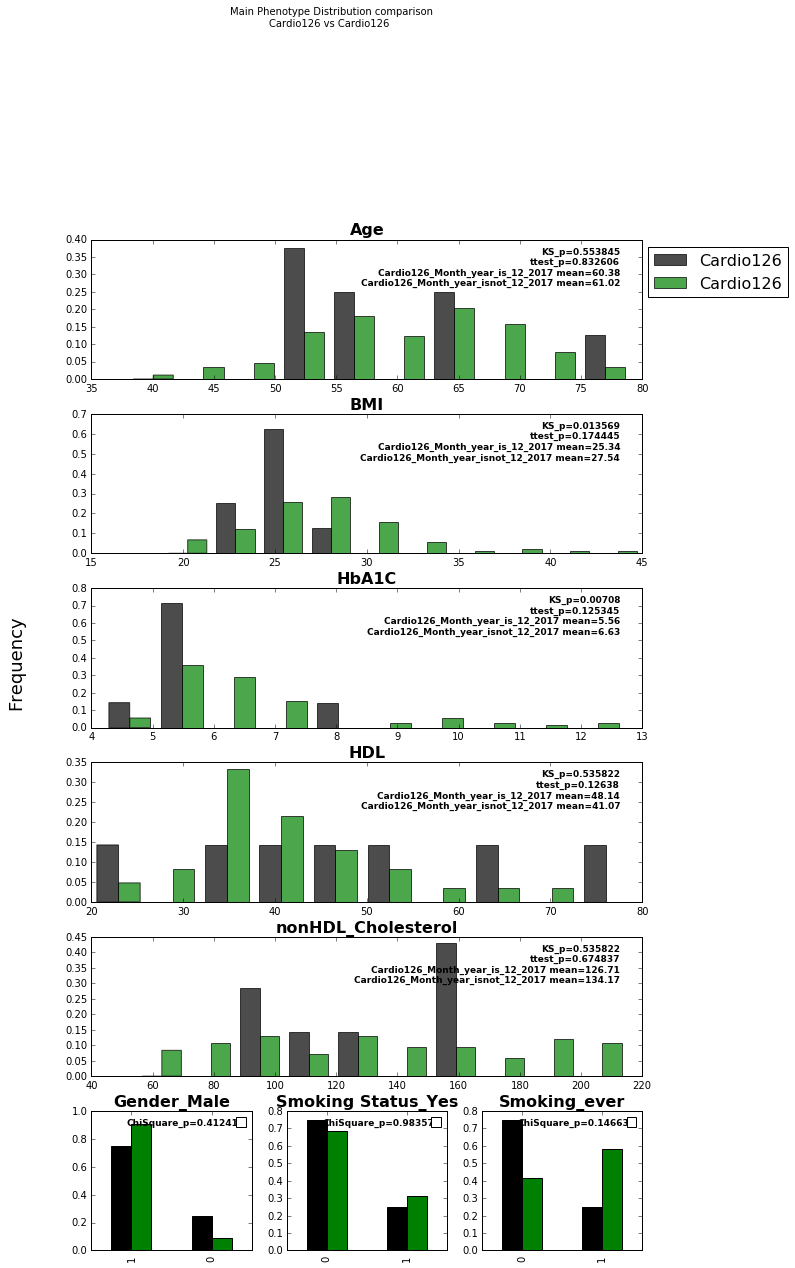

figure was saved in folder TCR_real_data/realAnalysis
done


In [301]:
dates_column='Month_year'
dates_value='12_2017'
datasetName='Cardio126'

fig1=compare_phenotypes_diff_seasons(dates_column,dates_value,datasetName)

number of samples in sampleList1=12
number of samples in sampleList2=85
0 Age
1 BMI
2 HbA1C
3 HDL
4 nonHDL_Cholesterol
0 Gender_Male
1 Smoking Status_Yes
2 Smoking_ever


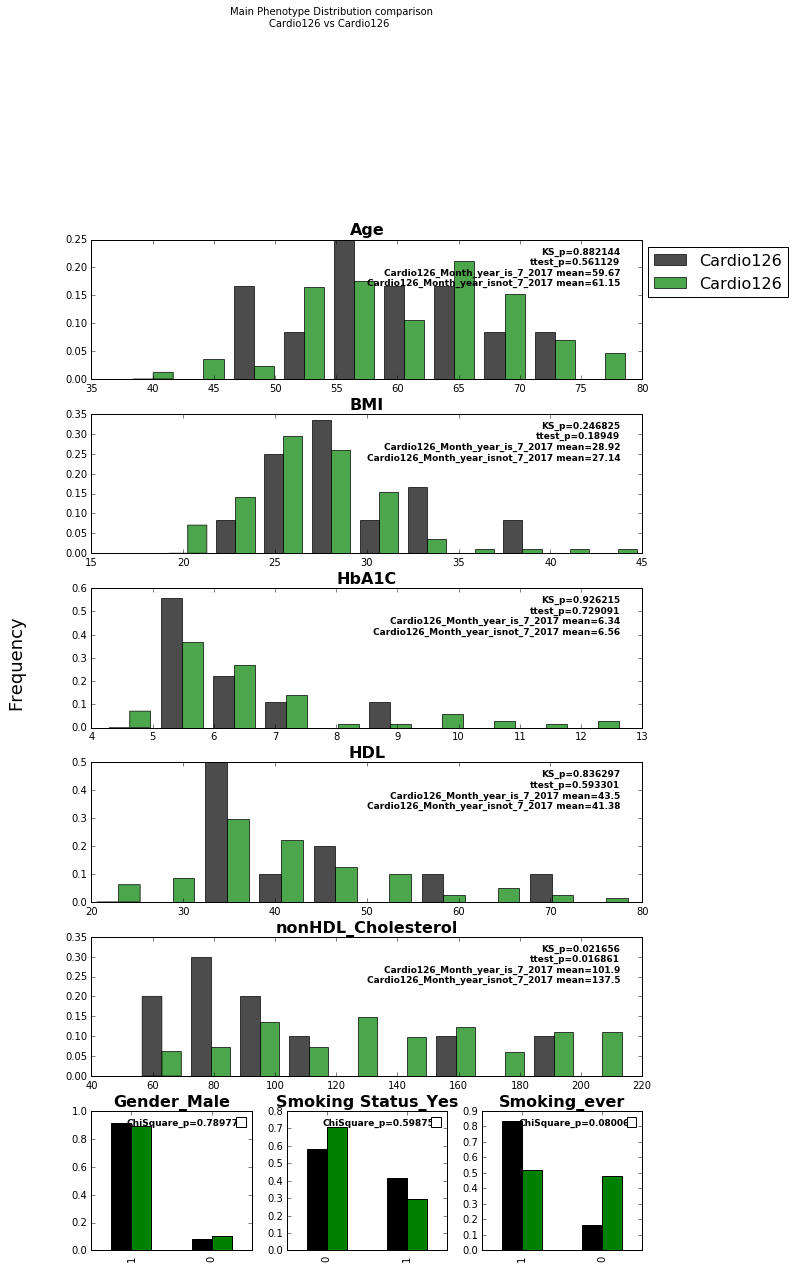

figure was saved in folder TCR_real_data/realAnalysis
done


In [302]:
dates_column='Month_year'
dates_value='7_2017'
datasetName='Cardio126'

fig1=compare_phenotypes_diff_seasons(dates_column,dates_value,datasetName)

# CHECK PREDICTION RESULTS WITH PERMUTATIONS:

## generate target files:

### pnp530:

In [317]:
dates_PNP530=pd.read_excel('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/seasonality/\
dates_targets.xlsx').set_index('BD')
dates_PNP530.head()

,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_12,Year_2013,...,Month_year_7_2014,Month_year_7_2015,Month_year_8_2014,Season_year_automn_2014,Season_year_automn_2015,Season_year_spring_2015,Season_year_summer_2014,Season_year_summer_2015,Season_year_winter_2013,Season_year_winter_2014
BD,,,,,,,,,,,,,,,,,,,,,
BD406,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
BD228,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BD714,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
BD808,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
BD144,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [465]:
pnp_target_list=['Month_year_3_2015','Month_year_2_2014','Year_2015','Year_2013','Month_year_7_2015','Year_2014',
                'Season_year_summer_2014','Month_year_6_2014']

for target in pnp_target_list:
    print target
    try:
        new_dates=dates_PNP530[target]
        new_dates.to_excel('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/seasonality/target_files/\
PNP530/%s.xlsx' %target)
    except:
        print 'couldnt execute'

Month_year_3_2015
Month_year_2_2014
Year_2015
Year_2013
Month_year_7_2015
Year_2014
Season_year_summer_2014
Month_year_6_2014


### Cardio126:

In [319]:
dates_Cardio126=pd.read_excel('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/seasonality/\
dates_targets_cardio.xlsx').set_index('BD')
dates_Cardio126.head()

,Month_1,Month_3,Month_4,Month_5,Month_6,Month_7,Month_9,Month_12,Year_2017,Year_2018,...,Month_year_3_2017,Month_year_4_2017,Month_year_5_2017,Month_year_6_2017,Month_year_7_2017,Month_year_9_2017,Season_year_automn_2017,Season_year_spring_2017,Season_year_summer_2017,Season_year_winter_2017
BD,,,,,,,,,,,,,,,,,,,,,
BD950,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
BD951,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
BD952,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
BD953,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
BD955,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0


In [320]:
cardio_target_list=['Month_1','Month_year_4_2017','Month_year_12_2017','Year_2018','Season_year_summer_2017','Month_year_7_2017']

for target in cardio_target_list:
    print target
    try:
        new_dates=dates_Cardio126[target]
        new_dates.to_excel('/net/mraid08/export/genie/Lab/Personal/ShaniBAF/TCR_real_data/seasonality/target_files/\
Cardio126/%s.xlsx' %target)
    except:
        print 'couldnt execute'

Month_1
Month_year_4_2017
Month_year_12_2017
Year_2018
Season_year_summer_2017
Month_year_7_2017
